# Predicting the fuel efficiency of car models
The overall goal is to predict the fuel efficiency of car models based on historical data collected
by the department of energy that can be found at
https://www.fueleconomy.gov/feg/download.shtml

In [121]:
import seaborn as sns
import os
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split as sksplit 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import scale, PolynomialFeatures
from sklearn import linear_model as lm
from sklearn import preprocessing
import fancyimpute
import datetime
import matplotlib.pyplot as plt
import missingno as msno
from sklearn import ensemble
##To remove unnecessary warning messages Ex:Deprecated APIs, Dataframe transformations 'in place'
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.latex.longtable',False)
pd.set_option("display.latex.repr", False)

## Data Preprocessing

### Loading data of three years (2015, 2016, 2017)
**Source** - https://www.fueleconomy.gov/feg/download.shtml

In [3]:
raw_data_15 = pd.read_excel('2015Mercedesforpublic.xlsx')

raw_data_16 = pd.read_excel('2016Mercedesforpublic.xlsx')

raw_data_17 = pd.read_excel('2017MercedesCadillacforpublic.xlsx')

Combining data from all three years to a single Data Frame for convenience

In [4]:
data_15_16 = raw_data_15.append(raw_data_16,ignore_index=True)
data_15_16_17 = data_15_16.append(raw_data_17, ignore_index=True)

In [5]:
raw_data_allyears= data_15_16_17.copy(deep=True)
print('Shape of the dataset is {}'.format(raw_data_allyears.shape))

Shape of the dataset is (3701, 162)


### Viewing columns and removing columns that are not required

* **Removing **EPA** as per Piazza discussion:**

In [6]:
data_columns = list(raw_data_allyears.columns)

data_columns_no_epa = [ x for x in data_columns if 'EPA' not in x]

print('Number of features after removing features containing \'EPA\' :{}'.format(
    len(data_columns_no_epa)))

Number of features after removing features containing 'EPA' :147


In [7]:
raw_data_allyears_noEPA = raw_data_allyears[data_columns_no_epa]

* **Finding the number of unique values in every columns:**

In [8]:
columns_nunique = pd.DataFrame(raw_data_allyears_noEPA.nunique(),columns = ['n'])

* **Viewing and dropping columns with zero information (no. of unique values = 0):**

In [9]:
columns_with_zeros = list(columns_nunique[columns_nunique['n']==0].index)

In [11]:
print('The following columns will be dropped because they do not contain data:\n {}'.format
      (columns_nunique[columns_nunique['n']==0]))

The following columns will be dropped because they do not contain data:
                                                     n
Unnamed: 74                                         0
Energy Storage Device,If Other                      0
Battery Type, If Other                              0
Fuel Cell Desc                                      0
Usable H2 Fill Capacity (kg)                        0
Fuel Cell Onboard H2 Capacity (kg)                  0
Fuel Metering Type 1 Desc                           0
Fuel Metering Type 2 Desc                           0
Charge Depleting Calc Appr Code (PHEV only)         0
Charge Depleting Calc Appr Desc (PHEV only)         0
Charge Sustaining Calc Appr Code (PHEV only)        0
Charge Sustaining Calc Appr Desc (PHEV only)        0
Unnamed: 130                                        0
#4 Smog Rating Test Group                           0
#4 Mfr Smog Rating (Mfr Smog 1-10 Rating on Lab...  0
CO2-PHEV Composite Rounded Adjusted Combined CO2    0
240V Char

In [12]:
raw_data_allyears_noEPA.drop(columns_with_zeros,axis = 1,inplace = True)

print("Data shape after removing NaN columns: {}".format(raw_data_allyears_noEPA.shape))

Data shape after removing NaN columns: (3701, 125)


* ** Removing constant valued columns (no. of unique values = 1):**

In [13]:
columns_nunique_n = pd.DataFrame(raw_data_allyears_noEPA.nunique(),columns = ['n'])

In [14]:
columns_nunique_1 = columns_nunique_n[columns_nunique_n.n == 1]
#raw_data_allyears_noEPA[list(columns_nunique_1.index)]

In [15]:
print('The following columns will be dropped because they are constant \
      valued and do not effect the model prediction: \n {}'.format(columns_nunique_1))

The following columns will be dropped because they are constant       valued and do not effect the model prediction: 
                                                     n
Guzzler?                                            1
Trans, Other                                        1
Fuel Unit - Conventional Fuel                       1
Fuel Unit Desc - Conventional Fuel                  1
Fuel2 Unit - Alternative Fuel                       1
Fuel2 Unit Desc - Alternative Fuel                  1
Suppressed?                                         1
Police/Emerg?                                       1
Energy Storage Device Desc                          1
Comments                                            1
# Capacitors                                        1
Fuel Cell Vehicle (Y or N)                          1
#3 Smog Rating Test Group                           1
#3 Mfr Smog Rating (Mfr Smog 1-10 Rating on Lab...  1


In [16]:
raw_data_allyears_noEPA.drop(list(columns_nunique_1.index),axis = 1,inplace=True)

print('Data shape after dropping signle values columns: {}'.format(
    raw_data_allyears_noEPA.shape))

Data shape after dropping signle values columns: (3701, 111)


* **Checking feature data sparsity:**

In [17]:
df_sparsity = pd.DataFrame(raw_data_allyears_noEPA.isnull().sum()/raw_data_allyears_noEPA.shape[0]
                           ,columns=['sparsity'])

In [18]:
df_sparsity[df_sparsity.sparsity > 0.9].sort_values(by='sparsity', ascending = False)

,sparsity
"Regen Braking Type, If Other",0.999189
Relabel,0.995407
HEV-EV Comments,0.994596
Relabel Desc,0.994056
"Motor Gen Type, If Other",0.986490
Max Biodiesel %,0.978654
Driver Cntrl Regen Braking?,0.964604
"Regen Braking Wheels Source (Front, Rear, Both)",0.964604
Battery Type Desc,0.963523
# Batteries,0.963523


In [19]:
sparse_columns_90 = list(df_sparsity[df_sparsity.sparsity > 0.90].index)
sparse_columns_95 = list(df_sparsity[df_sparsity.sparsity > 0.95].index)
sparse_columns_99 = list(df_sparsity[df_sparsity.sparsity > 0.99].index)

* **Removing columns with sparsity greater than 95%:**

In [20]:
print('The following columns will be dropped because they are more than 95% sparse: \n')
sparse_columns_95 

The following columns will be dropped because they are more than 95% sparse: 



['Max Biodiesel %',
 'Relabel',
 'Relabel Desc',
 '# Batteries',
 'Battery Type Desc',
 'Total Voltage for Battery Pack(s)',
 'Batt Energy Capacity (Amp-hrs)',
 'Batt Specific Energy (Watt-hr/kg)',
 'Batt Charger Type Desc',
 'Regen Braking Type Desc',
 'Regen Braking Type, If Other',
 'Regen Braking Wheels Source (Front, Rear, Both)',
 'Driver Cntrl Regen Braking?',
 'HEV-EV Comments',
 '# Drive Motor Gen',
 'Motor Gen Type Desc',
 'Motor Gen Type, If Other',
 'Rated Motor Gen Power (kW)']

In [21]:
raw_data_allyears_noEPA.drop(sparse_columns_95,axis=1,inplace=True)

print('Shape of the data after removing sparse features: {} '.format(
    raw_data_allyears_noEPA.shape))

Shape of the data after removing sparse features: (3701, 93) 


* **Dropping Target variable from the model data:**

In [22]:
target= raw_data_allyears['Comb Unrd Adj FE - Conventional Fuel'].copy(deep=True)

In [23]:
raw_data_allyears_noEPA.drop('Comb Unrd Adj FE - Conventional Fuel',inplace=True,axis=1)

* **Finding Column Correlations:**

In [24]:
column_correlation = raw_data_allyears_noEPA.corr(method='pearson', min_periods=1)

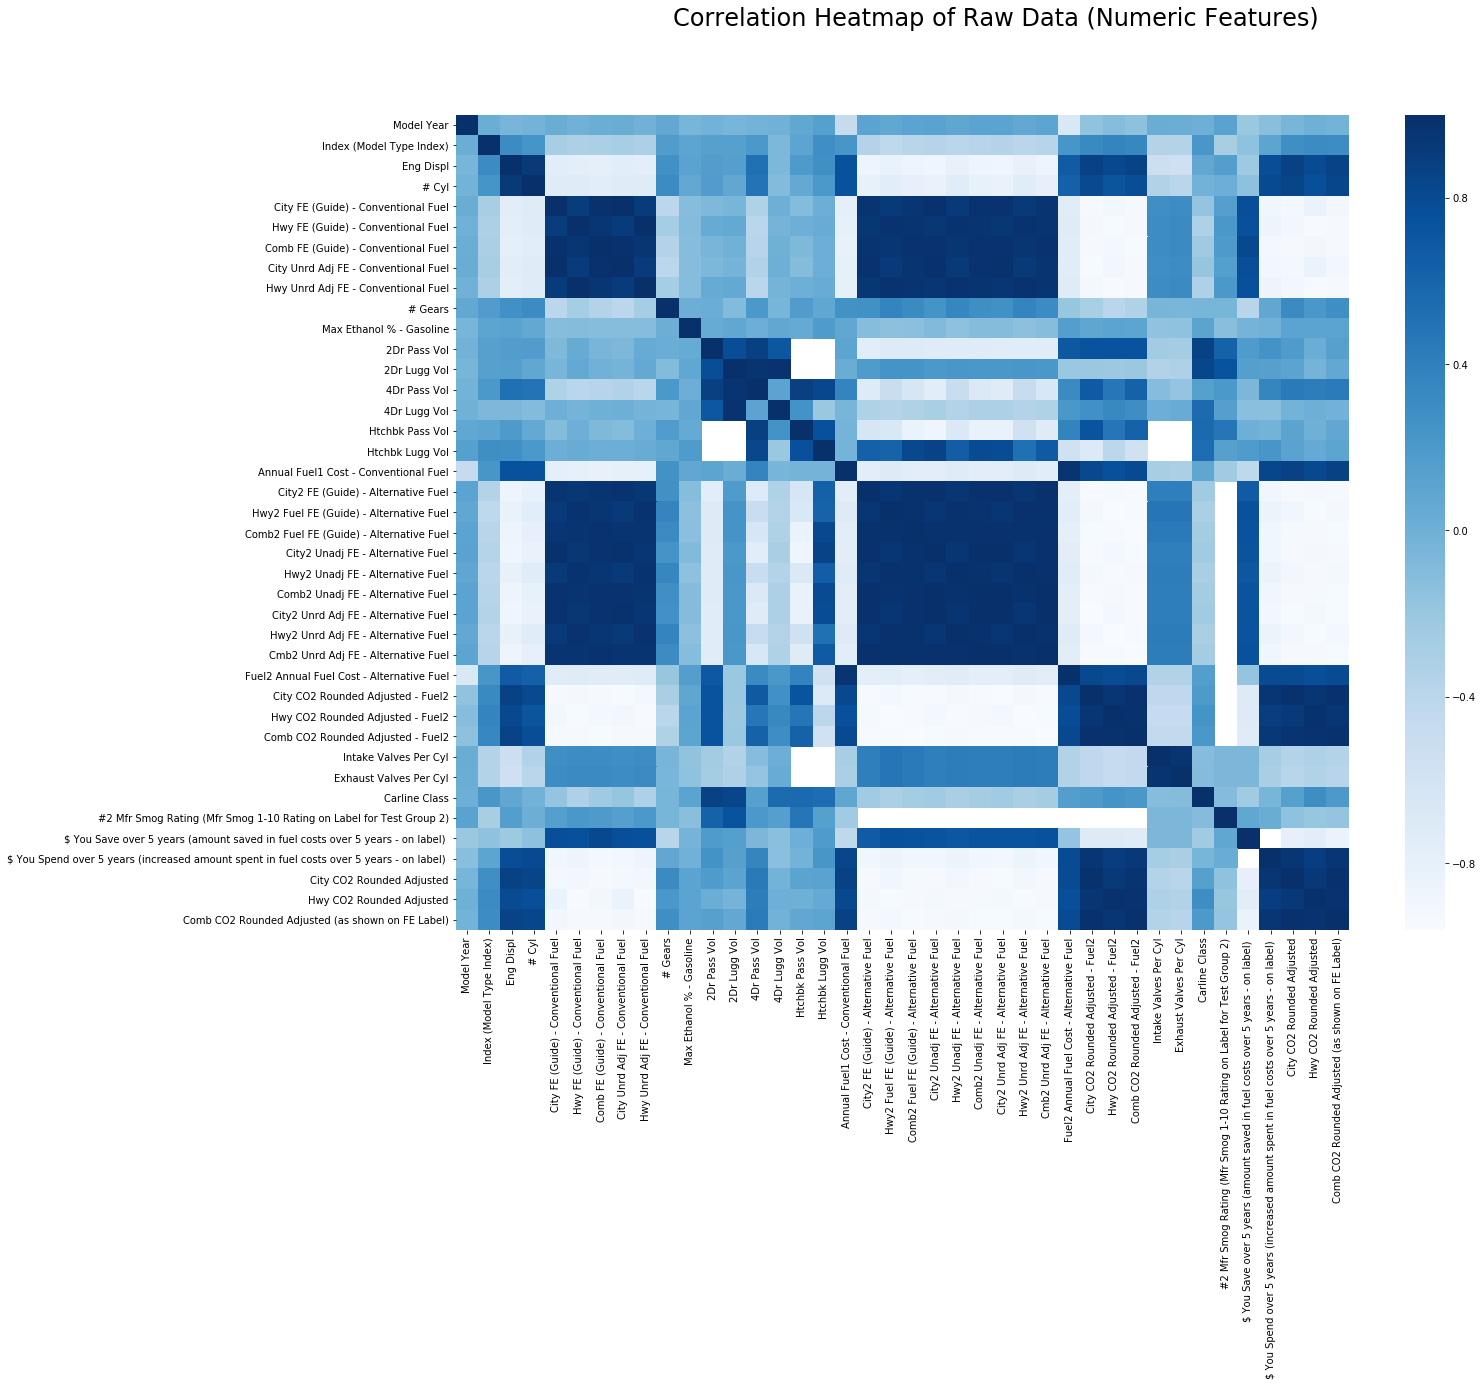

In [25]:
plt.figure(figsize=(20,15))
sns.heatmap(column_correlation, cmap = 'Blues')
plt.suptitle('Correlation Heatmap of Raw Data (Numeric Features)', fontsize = 24)
plt.show()

**In the above correlation heatmap, we observe that there is high correlation among certain features which needs   to be handled. We further explore the relationship between the features and the target:**

### Segregating continuous valued features and categorical features:

In [26]:
col_dtypes = pd.DataFrame(raw_data_allyears_noEPA.dtypes,columns = ['dtype'])

In [27]:
dicrete_cols = col_dtypes[col_dtypes.dtype == 'object']

#raw_data_allyears_noEPA[list(dicrete_cols.index)]

* We observe **a few numeric columns as 'object' dtype due to the presence of "Mod"** so we remove Mod values 
  and convert to float type

* **Dropping 'garbage values' in columns and modifying dtypes accordingly:**

In [28]:
drop_rows_mod = raw_data_allyears_noEPA[
    raw_data_allyears_noEPA['City Unadj FE - Conventional Fuel'] == "Mod"].index

In [29]:
print('There are {} rows with \'Mod\' value in every columns so we \
      go ahead and remove them'.format( len(drop_rows_mod)))

There are 7 rows with 'Mod' value in every columns so we       go ahead and remove them


In [30]:
raw_data_allyears_noEPA.drop(list(drop_rows_mod),inplace=True)   

#updating Target as well
target.drop(list(drop_rows_mod),inplace=True)   

* **Removing more 'Mod' values from some columns:**

In [31]:
raw_data_allyears_noEPA[
    'GHG Rating (1-10 rating on Label)'].replace('Mod',11, inplace=True)
raw_data_allyears_noEPA[
    '#1 Mfr Smog Rating (Mfr Smog 1-10 Rating on Label for Test Group 1)'].replace(
    'Mod',11, inplace=True)
raw_data_allyears_noEPA[
    'FE Rating (1-10 rating on Label)'].replace('Mod',11, inplace=True)

* **We then parse the numeric columns to "float64" after dropping garbage strings.**

In [32]:
discrete_value_data = raw_data_allyears_noEPA[list(dicrete_cols.index)]
cols = discrete_value_data.columns
row_list = []
for c in cols:
    try:
        raw_data_allyears_noEPA[c] = raw_data_allyears_noEPA[c].astype('float64')
    except ValueError as err:
        pass
        #print("Could not parse column {} because of {}".format(c,err))
            

We converted as many 'object' dtype columns to float as possible and got a final list of Float valued columns

* **Coverting **'datetime'** type columns to float:**

In [33]:
def convert_time_to_float(timestamp):
    return((timestamp - datetime.datetime(1992, 1, 17)).total_seconds())

In [34]:
date_col = col_dtypes[col_dtypes.dtype == 'datetime64[ns]'].index[0]
raw_data_allyears_noEPA[date_col] = raw_data_allyears_noEPA[date_col].apply(
    convert_time_to_float)

col_dtypes_new = pd.DataFrame(raw_data_allyears_noEPA.dtypes,columns=['dtype'])
#col_dtypes_new.dtype.value_counts()

In [35]:
object_cols = list(col_dtypes[col_dtypes.dtype == 'object'].index)

float_cols = list(col_dtypes[col_dtypes.dtype == 'float64'].index)

int_cols = list(col_dtypes[col_dtypes.dtype == 'int64'].index)


In [36]:
float_data_pd = raw_data_allyears_noEPA[float_cols].copy(deep=True)
int_data_pd = raw_data_allyears_noEPA[int_cols].copy(deep=True)
object_data_pd = raw_data_allyears_noEPA[int_cols].copy(deep=True)

* **Examining float valued features:**

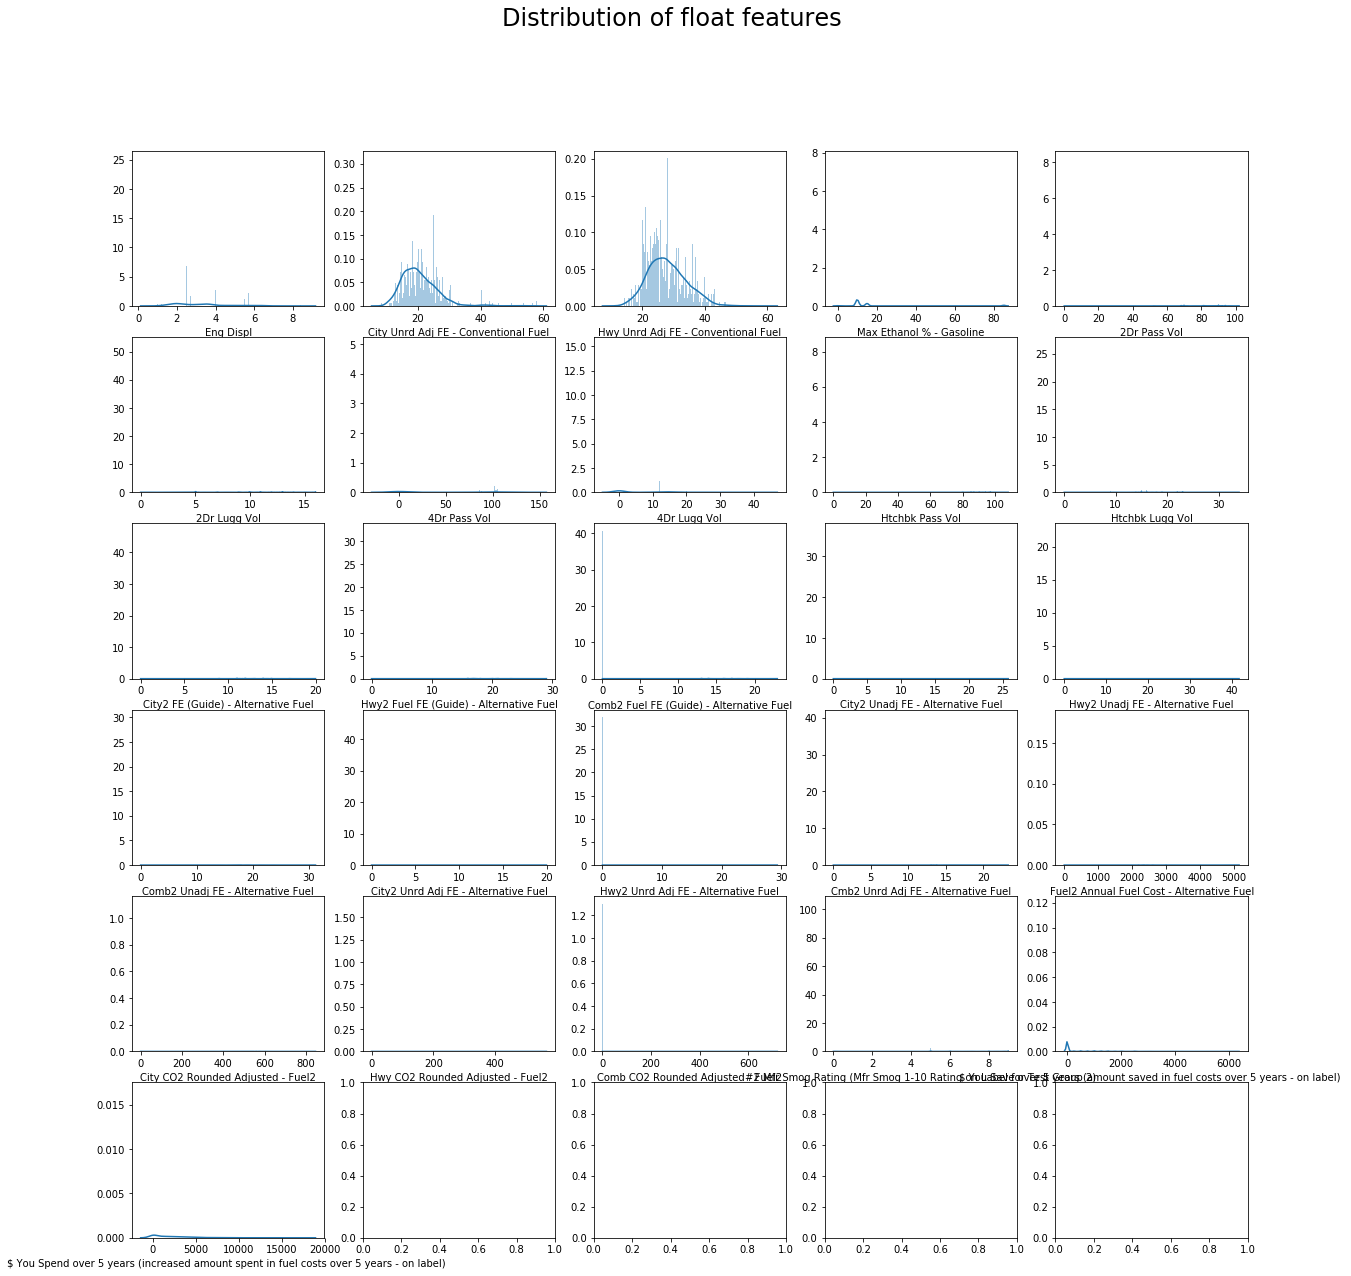

In [37]:
fig, ax_float = plt.subplots(6,5,figsize=(20,20)) 
float_c = list(float_data_pd.columns)
#scatter_kws_args={'alpha':0.13,'s':1,'color':'Navy'}
handles = {}
c=0
for i in range(6):
    for j in range(5): 
        column = float_c[c]
        sns.distplot(raw_data_allyears_noEPA[column].fillna(0),
                     ax=ax_float[i,j],bins = 1000)
        ax_float[i,j].set(xlabel=column)
        c += 1
        if c == len(float_c):
            break
        
plt.suptitle('Distribution of float features', fontsize=24)
plt.show()


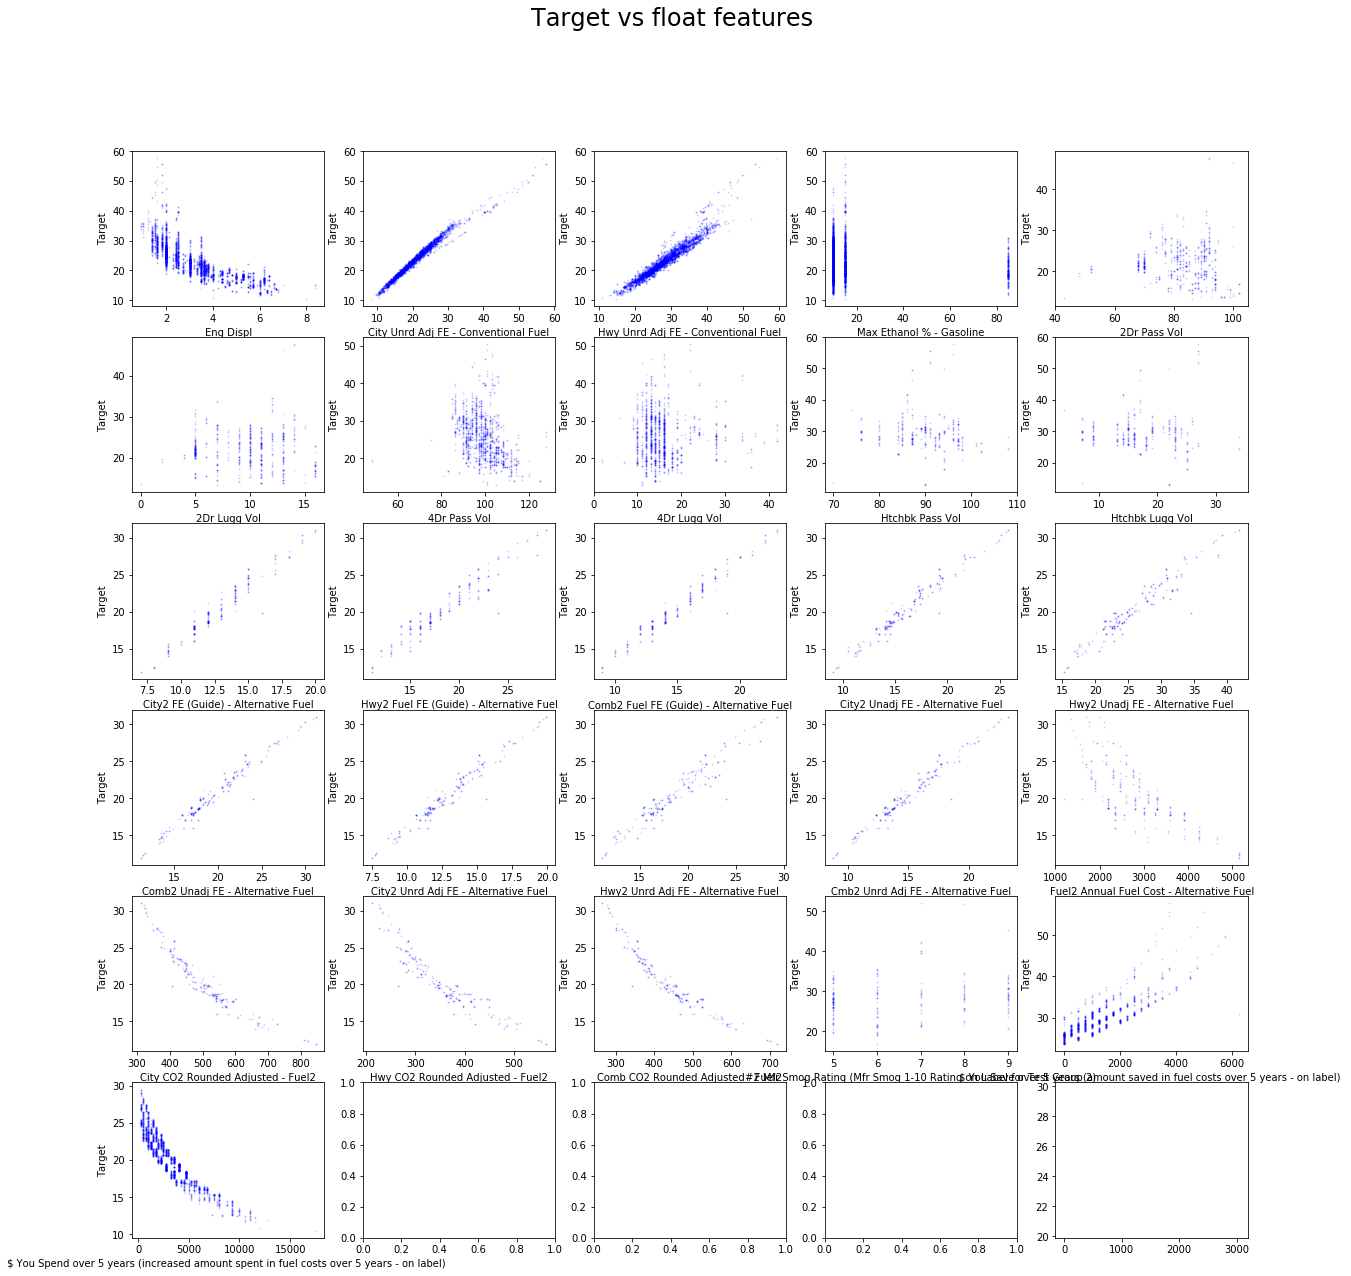

In [38]:
fig, ax_float = plt.subplots(6,5,figsize=(20,20)) 
float_c = list(float_data_pd.columns)
scatter_kws_args={'alpha':0.13,'s':1,'color':'Blue'}
handles = {}
c=0
for i in range(6):
    for j in range(5): 
        column = float_c[c]
        handles[column] = sns.regplot(x=raw_data_allyears_noEPA[column],
                                      y = target,ax=ax_float[i,j],
                                      fit_reg=False,
                                      scatter_kws=scatter_kws_args)
        ax_float[i,j].set(xlabel=column,ylabel='Target')
        c += 1
        if c == len(float_c):
            break
plt.suptitle('Target vs float features', fontsize=24)
plt.show()


In [39]:
#Get target column
target_df = pd.DataFrame(list(target),columns=['City Unadj FE - Conventional Fuel'])

**Evaluating correlation between features and target:**

In [40]:
#Calculating correlations between target and numeric features
columns = list(raw_data_allyears_noEPA.columns)
corr = {}
for c in columns:
    col_dtype = col_dtypes_new.loc[c,'dtype']
    if col_dtype == 'float64' or col_dtype == 'int64':
        corr[c] = raw_data_allyears_noEPA[c].corr(
            target_df['City Unadj FE - Conventional Fuel'])

feature_target_corr_df = pd.DataFrame.from_dict(corr,
                        orient='index').sort_values(by=[0],ascending = False)

In [41]:
feature_target_corr_df

,0
City2 Unadj FE - Alternative Fuel,0.762945
City2 Unrd Adj FE - Alternative Fuel,0.761112
Comb2 Unadj FE - Alternative Fuel,0.757202
City2 FE (Guide) - Alternative Fuel,0.755287
Cmb2 Unrd Adj FE - Alternative Fuel,0.754447
Comb2 Fuel FE (Guide) - Alternative Fuel,0.746895
Hwy2 Fuel FE (Guide) - Alternative Fuel,0.732231
Hwy2 Unadj FE - Alternative Fuel,0.723872
Hwy2 Unrd Adj FE - Alternative Fuel,0.723551
Hwy Unrd Adj FE - Conventional Fuel,0.547511


**We remove features that have high correlation with the target to avoid information leakage**

In [42]:
#Columns with high correlation with target
cols_to_drop = list(feature_target_corr_df[feature_target_corr_df[0] > 0.9].index)

In [43]:
#dropping high correlated columns with target
raw_data_allyears_noEPA.drop(cols_to_drop,axis=1,inplace=True)

* **Removing columns that are just descriptions:**

In [44]:
data_columns_descr = [ x for x in columns if 'Desc' in x]
print('The following columns will be dropped because they \
      are just descriptions: \n')
data_columns_descr

The following columns will be dropped because they       are just descriptions: 



['Air Aspiration Method Desc',
 'Trans Desc',
 'Drive Desc',
 'Fuel Usage Desc - Conventional Fuel',
 'Gas Guzzler Exempt Desc (Where Truck = 1975 NHTSA truck definition)',
 ' Fuel2 Usage Desc - Alternative Fuel',
 'Descriptor - Model Type (40 Char or less)',
 'Carline Class Desc',
 'Calc Approach Desc',
 'Cyl Deact Desc',
 'Var Valve Timing Desc',
 'Var Valve Lift Desc',
 'Fuel Metering Sys Desc',
 'Stop/Start System (Engine Management System)  Description',
 'Model Type Desc (MFR entered)']

In [45]:
raw_data_allyears_noEPA.drop(data_columns_descr,axis=1,inplace=True)

print('The shape of the dataset after dropping descriptions: {}'.
      format(raw_data_allyears_noEPA.shape))

The shape of the dataset after dropping descriptions: (3694, 77)


* **We drop columns that have high correlation among themselves:**

In [46]:
column_correlation = raw_data_allyears_noEPA.corr()

In [47]:
upper = column_correlation.where(np.triu(np.ones(column_correlation.shape),
                                         k=1).astype(np.bool))
cols = upper.columns
coll_corrs = {}
drop_col_list = []
for c in cols:
    c_col = upper[c]
    corr_90 = c_col[c_col > 0.9]
    corr_90 = corr_90[corr_90 <1]
    c_corr_cols = list(corr_90.index)
    add_drop_cols = [x for x in c_corr_cols 
                     if x not in drop_col_list and
                     x != 'Comb Unrd Adj FE - Conventional Fuel']
    drop_col_list.extend(add_drop_cols)
    coll_corrs[c] = c_corr_cols
    

In [48]:
print('The following columns will be dropped because they are linearly correlated: \n')
drop_col_list

The following columns will be dropped because they are linearly correlated: 



['Eng Displ',
 'City FE (Guide) - Conventional Fuel',
 'Hwy FE (Guide) - Conventional Fuel',
 'Comb FE (Guide) - Conventional Fuel',
 'City Unadj FE - Conventional Fuel',
 'Hwy Unadj FE - Conventional Fuel',
 'Comb Unadj FE - Conventional Fuel',
 'City Unrd Adj FE - Conventional Fuel',
 '2Dr Lugg Vol',
 'Hwy Unrd Adj FE - Conventional Fuel',
 'City2 FE (Guide) - Alternative Fuel',
 'Hwy2 Fuel FE (Guide) - Alternative Fuel',
 'Comb2 Fuel FE (Guide) - Alternative Fuel',
 'City2 Unadj FE - Alternative Fuel',
 'Hwy2 Unadj FE - Alternative Fuel',
 'Comb2 Unadj FE - Alternative Fuel',
 'City2 Unrd Adj FE - Alternative Fuel',
 'Hwy2 Unrd Adj FE - Alternative Fuel',
 'Annual Fuel1 Cost - Conventional Fuel',
 'City CO2 Rounded Adjusted - Fuel2',
 'Hwy CO2 Rounded Adjusted - Fuel2',
 'Intake Valves Per Cyl',
 'Model Year',
 'Cmb2 Unrd Adj FE - Alternative Fuel',
 'MFR Calculated Gas Guzzler MPG ',
 'FE Rating (1-10 rating on Label)',
 'Comb CO2 Rounded Adjusted - Fuel2',
 '$ You Spend over 5 yea

In [49]:
raw_data_allyears_noEPA_noCorr = raw_data_allyears_noEPA.drop(drop_col_list,axis = 1)

In [50]:
raw_data_allyears_noEPA_noCorr.shape

(3694, 47)

* **Vizualizing data distributions:**

In [51]:
raw_data = raw_data_allyears_noEPA_noCorr.copy(deep = True)
encoded_data = raw_data_allyears_noEPA_noCorr.copy(deep = True)

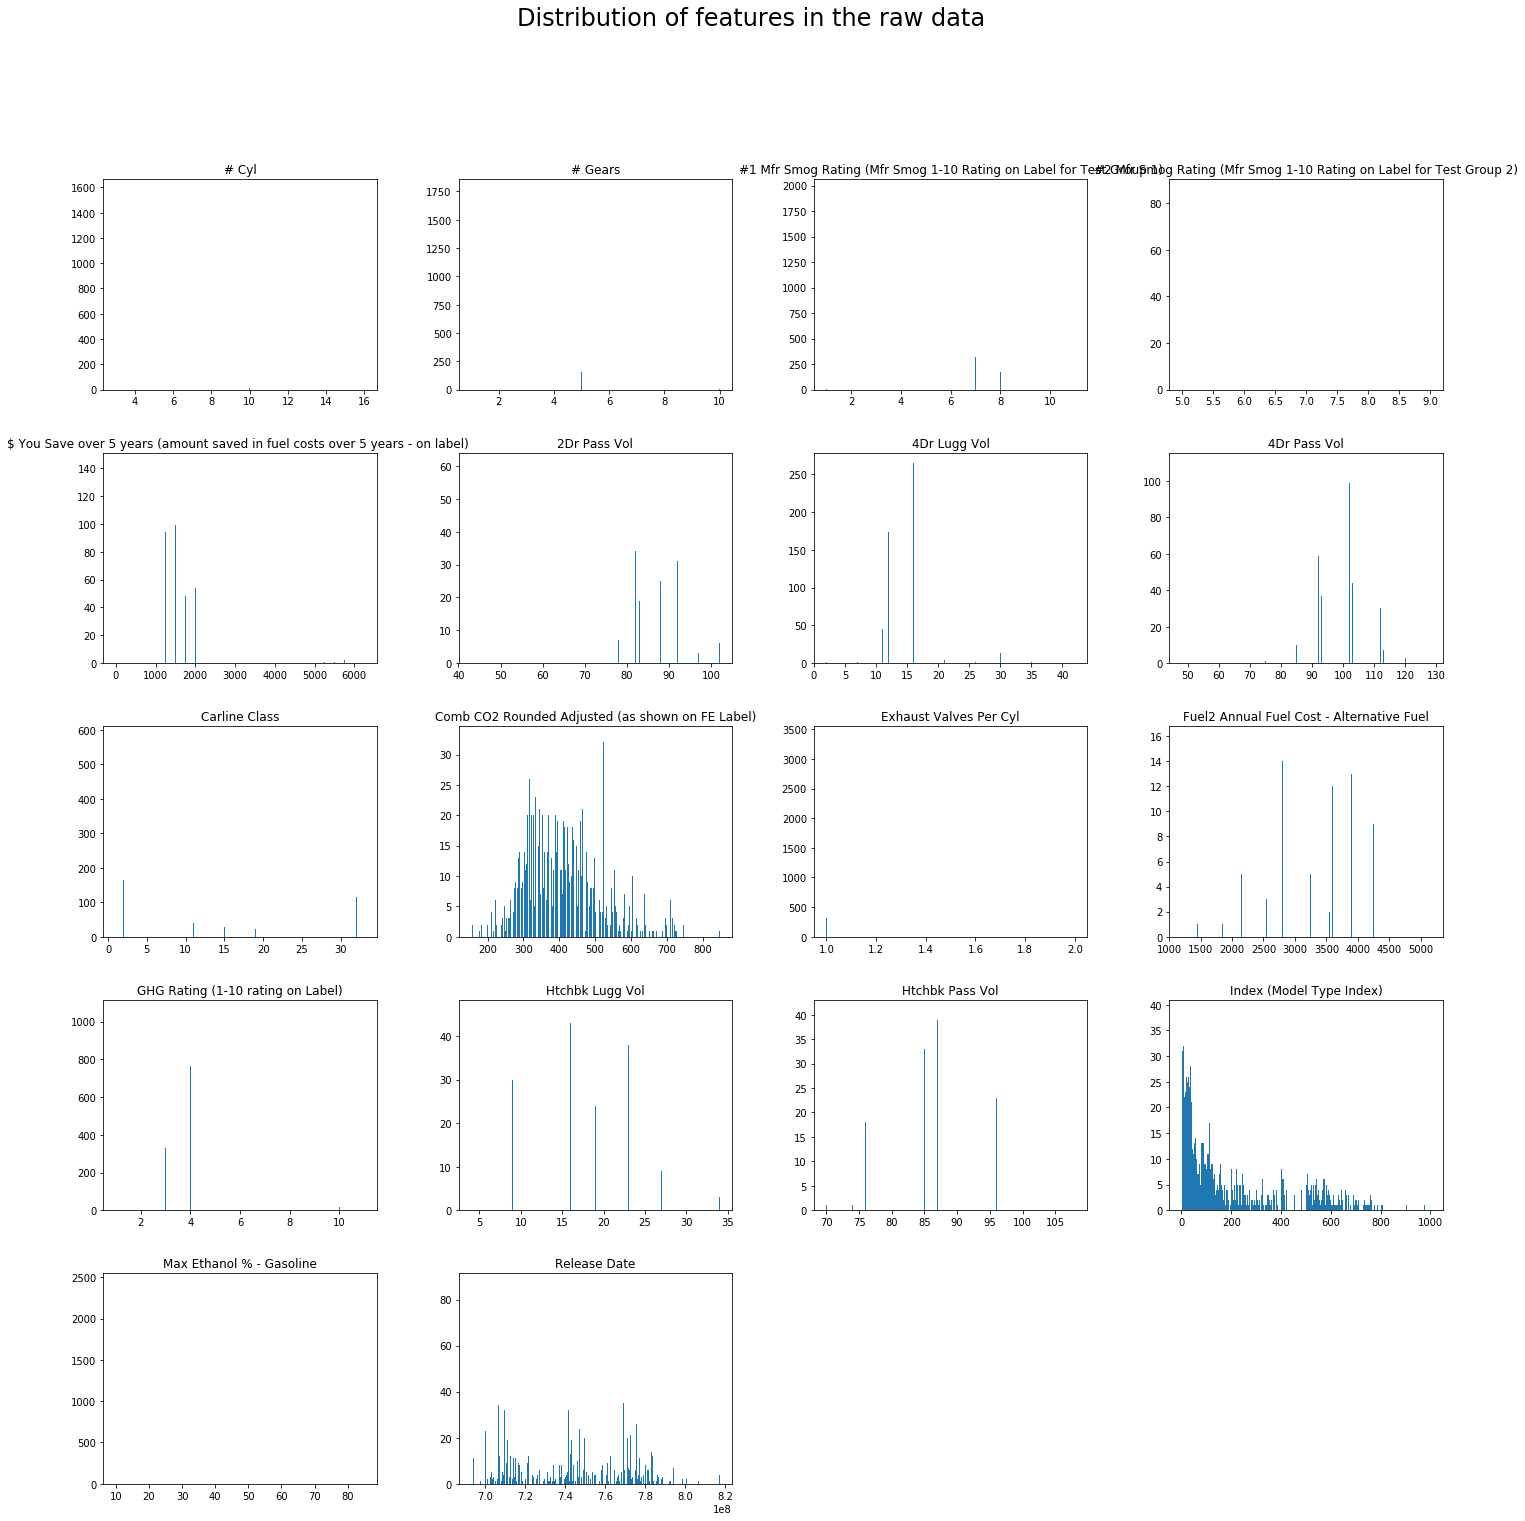

In [52]:
raw_data.hist(figsize=(24,24),bins=1000,grid=False,)
plt.suptitle('Distribution of features in the raw data',fontsize = 24)
plt.show()

In [53]:
raw_data['y'] = list(target)

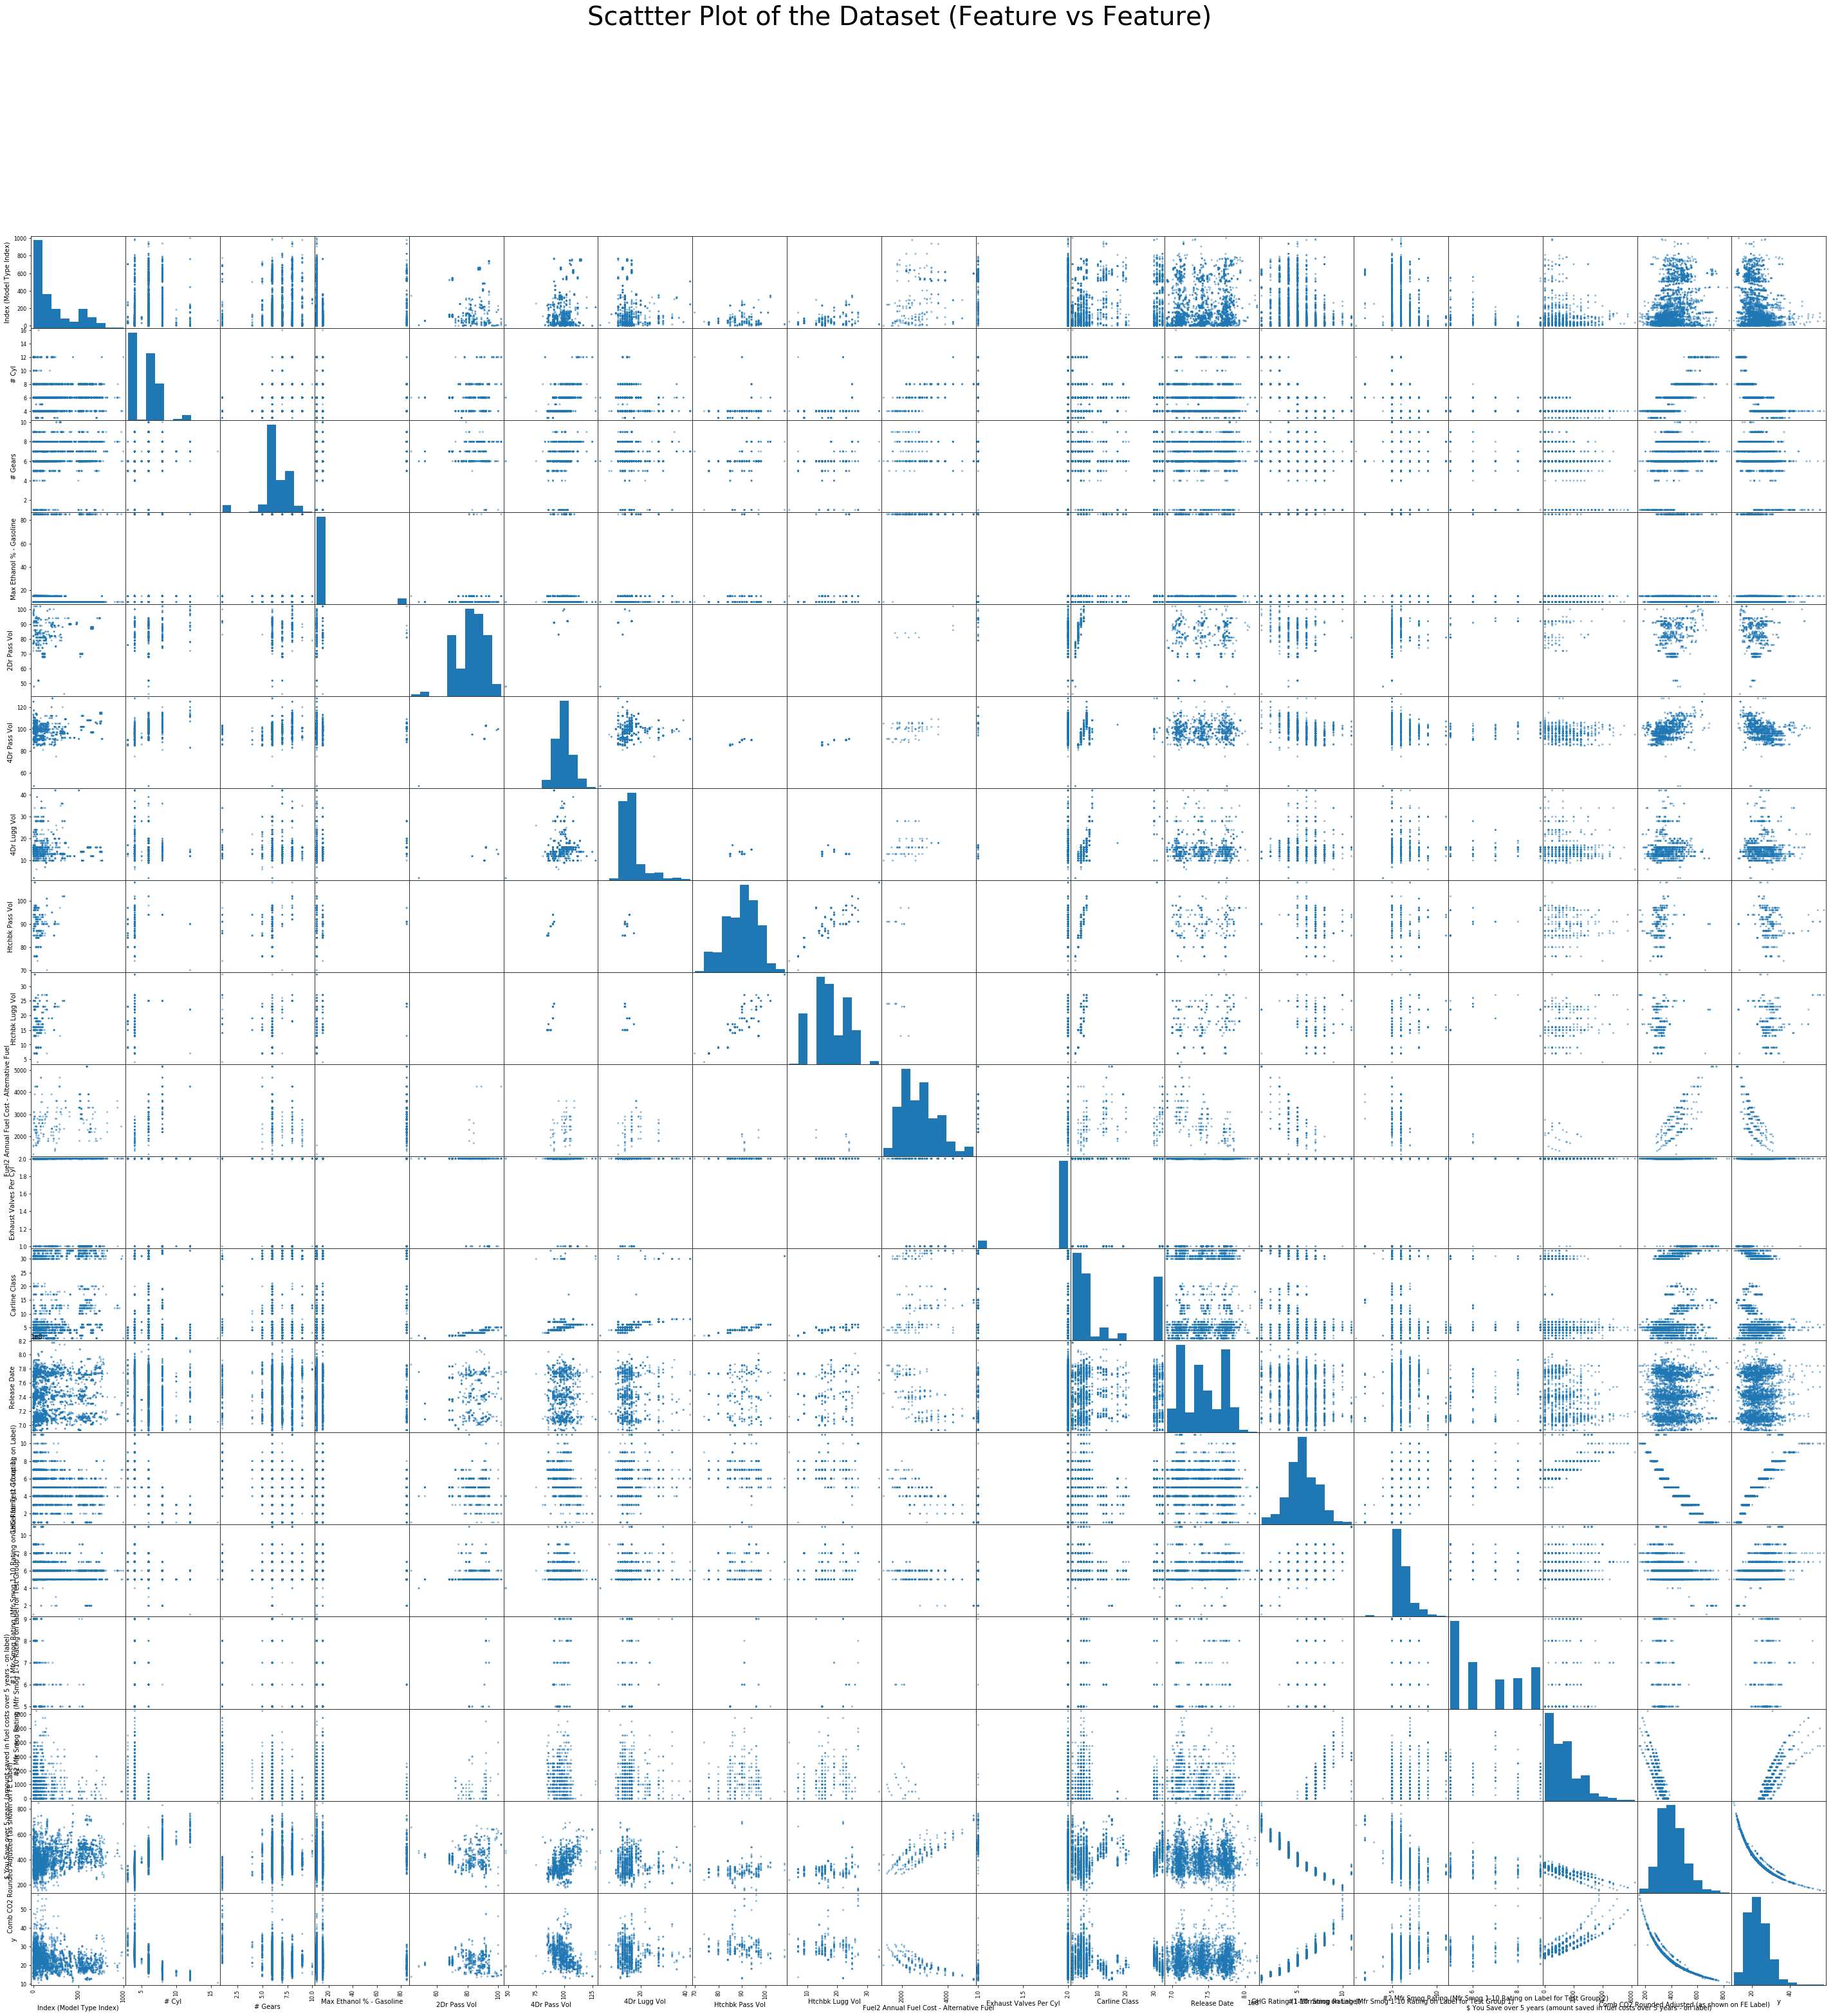

In [54]:
from pandas.plotting import scatter_matrix
scatter_matrix(raw_data,figsize = (50,50))
plt.suptitle('Scattter Plot of the Dataset (Feature vs Feature)',fontsize=40)
plt.savefig('scat_mat.png')
plt.show()

In [55]:
data_columns_rating = [ x for x in list(raw_data.columns) if 'Rating' in x]
print('The following columns will be dropped because \
      they are tail pipe emmission ratings: \n')
data_columns_rating

The following columns will be dropped because       they are tail pipe emmission ratings: 



['GHG Rating (1-10 rating on Label)',
 '#1 Smog Rating Test Group',
 '#1 Mfr Smog Rating (Mfr Smog 1-10 Rating on Label for Test Group 1)',
 '#2 Smog Rating Test Group',
 '#2 Mfr Smog Rating (Mfr Smog 1-10 Rating on Label for Test Group 2)']

In [56]:
raw_data.drop(data_columns_rating,inplace=True,axis=1)

In [57]:
raw_data.nunique()

Mfr Name                                                                           28
Division                                                                           49
Carline                                                                          1152
Verify Mfr Cd                                                                      28
Index (Model Type Index)                                                          656
# Cyl                                                                               8
Transmission                                                                       28
Air Aspir Method                                                                    3
Trans                                                                               7
# Gears                                                                             8
Lockup Torque Converter                                                             2
Trans Creeper Gear                                    

* **Further dropping irrelevant columns (using domain knowledge):**

In [58]:
drop_irrel_cols=[]

In [59]:
raw_data['Carline'].value_counts()

CAMARO                               22
ACCORD                               20
Jetta                                19
MUSTANG                              18
C15 SIERRA 2WD                       16
K15 SILVERADO 4WD                    16
K15 SIERRA 4WD                       16
C15 SILVERADO 2WD                    16
FOCUS FWD                            15
MAZDA3 4-Door                        15
Challenger                           15
MAZDA3 5-Door                        15
Elantra                              13
SONIC                                12
FRONTIER 2WD                         12
Patriot FWD                          12
SONIC 5                              12
Veloster                             12
500                                  12
ATS                                  12
CORVETTE                             12
TACOMA 4WD                           12
Beetle                               12
Compass FWD                          12
CANYON 2WD                           11


These are just car model names and do not give any information about our target

In [60]:
drop_irrel_cols.append('Carline')

We drop **viscocity** also because using it as categories would overfit our model

In [61]:
drop_irrel_cols.append('Oil Viscosity')

In [62]:
raw_data['Comments - Mfr Eng Cnfg'].value_counts()

Sonic 1.4L                                                                                                        40
2TWC, 2HO2S(2), DFI                                                                                               24
AFM                                                                                                               20
Base Carrera models                                                                                               20
Carrera S models                                                                                                  20
Base models                                                                                                       19
S models                                                                                                          16
M274-20DETC(C300 / C300 4MATIC and GLC 300 / GLC 300 4MATIC)                                                      15
Engine Code: CPMB                                               

These values cannot be fitted in a model so we drop this as well

In [63]:
drop_irrel_cols.append('Comments - Mfr Eng Cnfg')

** Examining the feature - 'Range1 - Model Type Driving Range - Conventional Fuel': **

In [64]:
range_col_list = list(raw_data[
    'Range1 - Model Type Driving Range - Conventional Fuel'])
range_clean = [x if '/' not in str(x) else np.NaN for x in range_col_list]

In [65]:
raw_data['Range1 - Model Type Driving Range - Conventional Fuel'] = range_clean

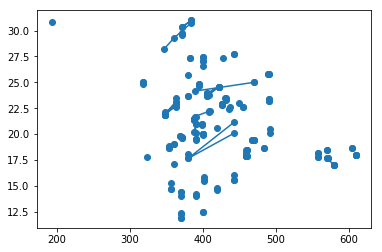

In [66]:
plt.plot(raw_data[
    'Range1 - Model Type Driving Range - Conventional Fuel'],target, '-o')
plt.show()

 No clear relation between the feature and the target. There is no info leak, we retain the column.

**Examining the feature '$ You Save over 5 years (amount saved in fuel costs over 5 years - on label) ':**

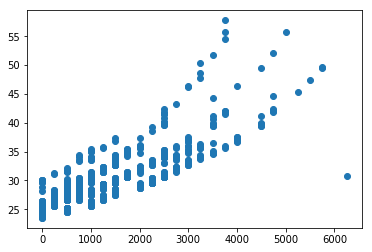

In [67]:
plt.plot(raw_data[
    '$ You Save over 5 years (amount saved in fuel costs over 5 years - on label) '],
         target,'o')
plt.show()

Non linearity between feature and target; we retain the feature

* **Dropping the above analyzed irrelevant features:**

In [68]:
raw_data.drop(drop_irrel_cols,axis=1,inplace=True)

In [69]:
raw_data.drop('y',axis=1,inplace=True)

print('Shape of the dataset after removing irrelevant columns: {}'.
      format(raw_data.shape))

Shape of the dataset after removing irrelevant columns: (3694, 39)


* **Making a final list of categorical columns: **

In [70]:
int_obj_cat_list = ['Max Ethanol % - Gasoline','# Cyl','# Gears',
                    'Exhaust Valves Per Cyl']
for col in int_obj_cat_list:
    raw_data[col] = raw_data[col].astype(object)

In [71]:
int_check = raw_data.dtypes == int
int_check_list = list(int_check[int_check == True].index)
for col in int_check_list:
    raw_data[col] = raw_data[col].astype(float)

In [72]:
cat_check = raw_data.dtypes == object
cat_check_list = list(cat_check[cat_check == True].index)

# Task 1 Linear Models
**Measure performance of a linear model using the provided features with appropriate
preprocessing.**

## Preparing data for fitting Linear Models

* **Encoding categorical columns: **

In [73]:
encoded_data = raw_data.copy(deep=True)
encoded_data.reset_index(drop=True, inplace=True)

In [74]:
le={}
for c in cat_check_list:
    le[c]= preprocessing.LabelEncoder()
    try:
        encoded_data[c] = le[c].fit_transform(raw_data[c].astype(str).values)
    except TypeError as terr:
        print("error in encodeing col {} due to  {}".format(c,terr))

In [75]:
for c in cat_check_list:
    if 'nan' in le[c].classes_:
        idx = np.where(le[c].classes_ =='nan')[0][0]
        encoded_data[c].replace(idx, np.NaN, inplace=True)

** Plot for visualizing data sparsity with white lines representing NAN values **

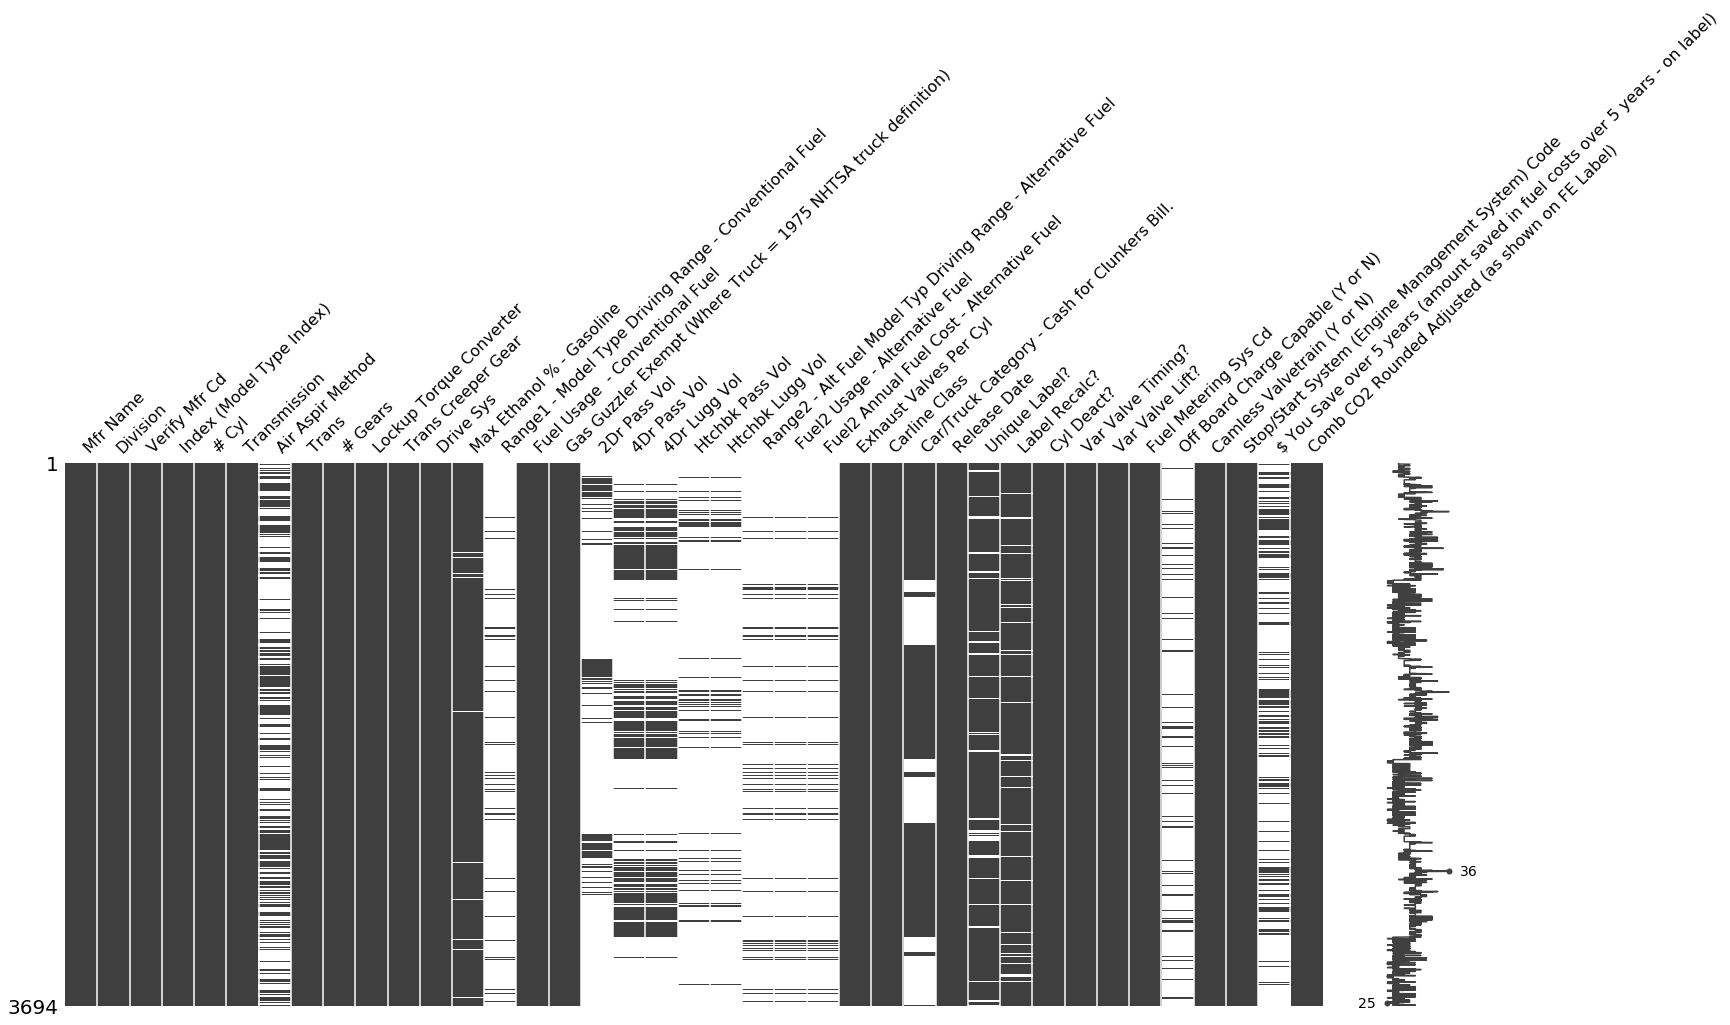

In [76]:
msno.matrix(encoded_data)

** Heatmap representing columns with same missing rows**

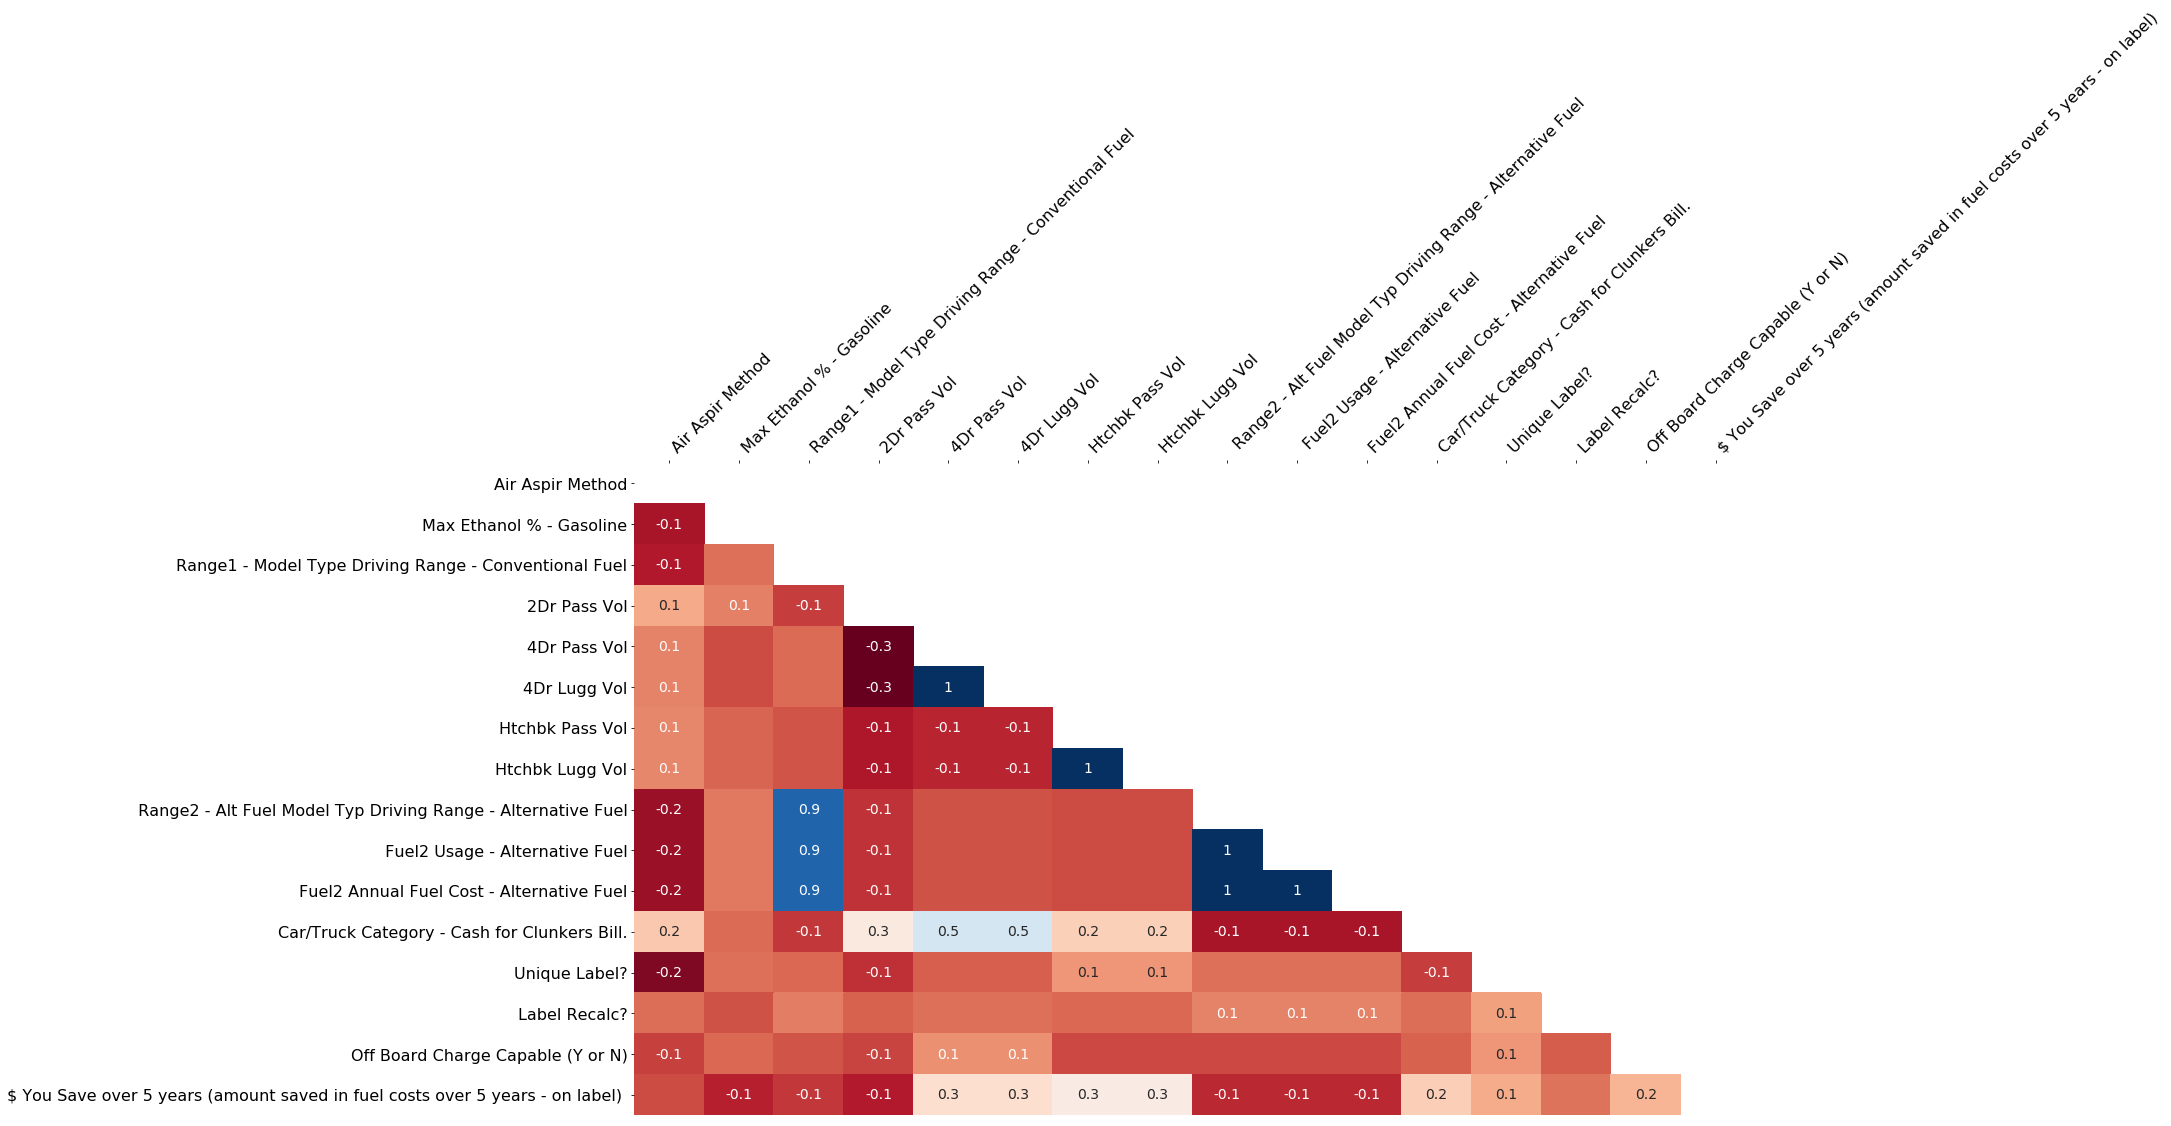

In [77]:
msno.heatmap(encoded_data)

* ** Imputing features using fancyimpute:**

In [79]:
float_check = raw_data.dtypes == float
float_check_list = list(float_check[float_check == True].index)
encoded_cont_data = encoded_data[float_check_list].values

In [80]:
try:
    mice = fancyimpute.MICE(verbose=0)
    encoded_cont_data_imputed = mice.complete(encoded_cont_data)
except TypeError as err:
    print(err)

In [81]:
cont_target_np = np.hstack((encoded_cont_data_imputed,
                            np.reshape(target, (target.shape[0],1))))

cov = np.corrcoef(cont_target_np, rowvar=False)

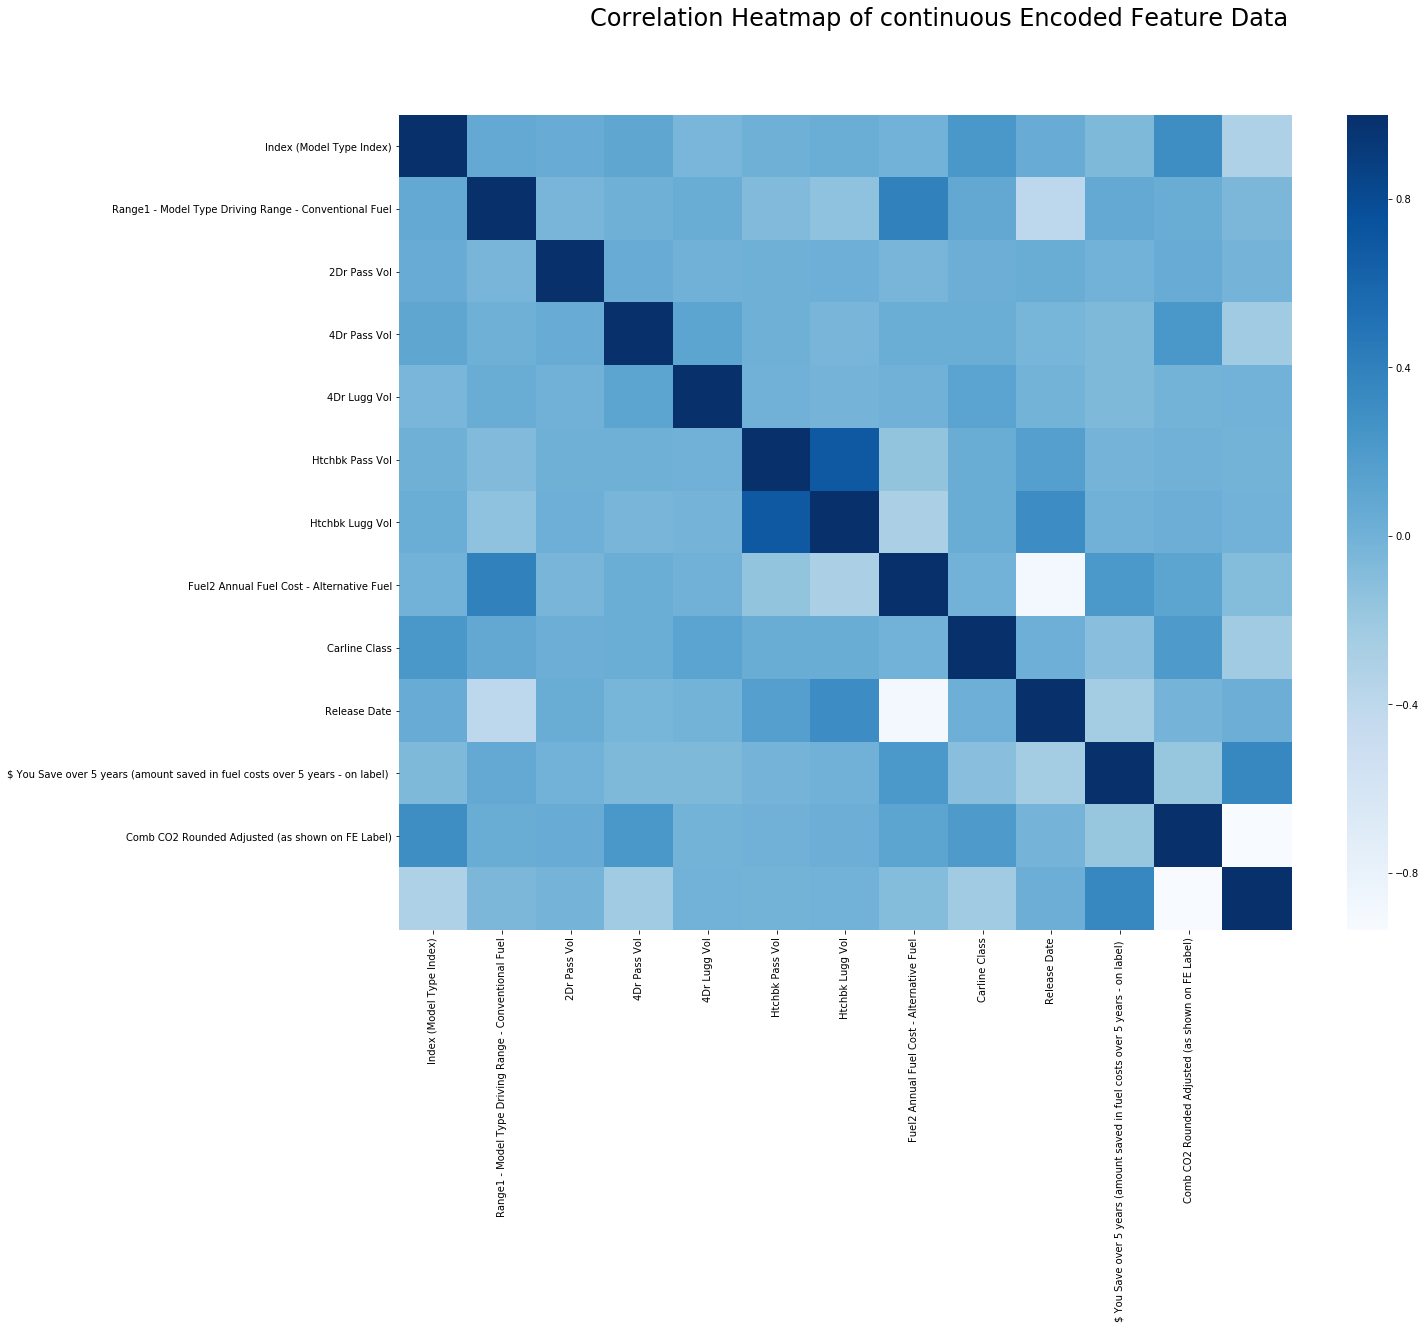

In [82]:
plt.figure(figsize=(20,15))
sns.heatmap(cov, cmap = 'Blues',xticklabels=float_check_list,
            yticklabels= float_check_list)
plt.suptitle('Correlation Heatmap of continuous Encoded Feature Data',
             fontsize = 24)
plt.show()

In [83]:
encoded_df = pd.DataFrame(encoded_cont_data_imputed, columns=float_check_list)
encoded_cat_df = pd.concat([encoded_df, encoded_data[cat_check_list]],axis=1)

In [84]:

try:
    knn = fancyimpute.KNN(k=5)
    encoded_cat_data_imputed = knn.complete(encoded_cat_df.values)
except TypeError as err:
    pass
    #print(err)
    
final_imputed_df = pd.DataFrame(encoded_cat_data_imputed, 
                                columns = encoded_cat_df.columns)

Imputing row 1/3694 with 3 missing, elapsed time: 3.350
Imputing row 101/3694 with 3 missing, elapsed time: 3.367
Imputing row 201/3694 with 4 missing, elapsed time: 3.376
Imputing row 301/3694 with 3 missing, elapsed time: 3.385
Imputing row 401/3694 with 3 missing, elapsed time: 3.396
Imputing row 501/3694 with 3 missing, elapsed time: 3.404
Imputing row 601/3694 with 4 missing, elapsed time: 3.420
Imputing row 701/3694 with 4 missing, elapsed time: 3.435
Imputing row 801/3694 with 5 missing, elapsed time: 3.443
Imputing row 901/3694 with 4 missing, elapsed time: 3.459
Imputing row 1001/3694 with 4 missing, elapsed time: 3.471
Imputing row 1101/3694 with 5 missing, elapsed time: 3.486
Imputing row 1201/3694 with 5 missing, elapsed time: 3.498
Imputing row 1301/3694 with 4 missing, elapsed time: 3.509
Imputing row 1401/3694 with 3 missing, elapsed time: 3.517
Imputing row 1501/3694 with 3 missing, elapsed time: 3.526
Imputing row 1601/3694 with 3 missing, elapsed time: 3.535
Imputing 

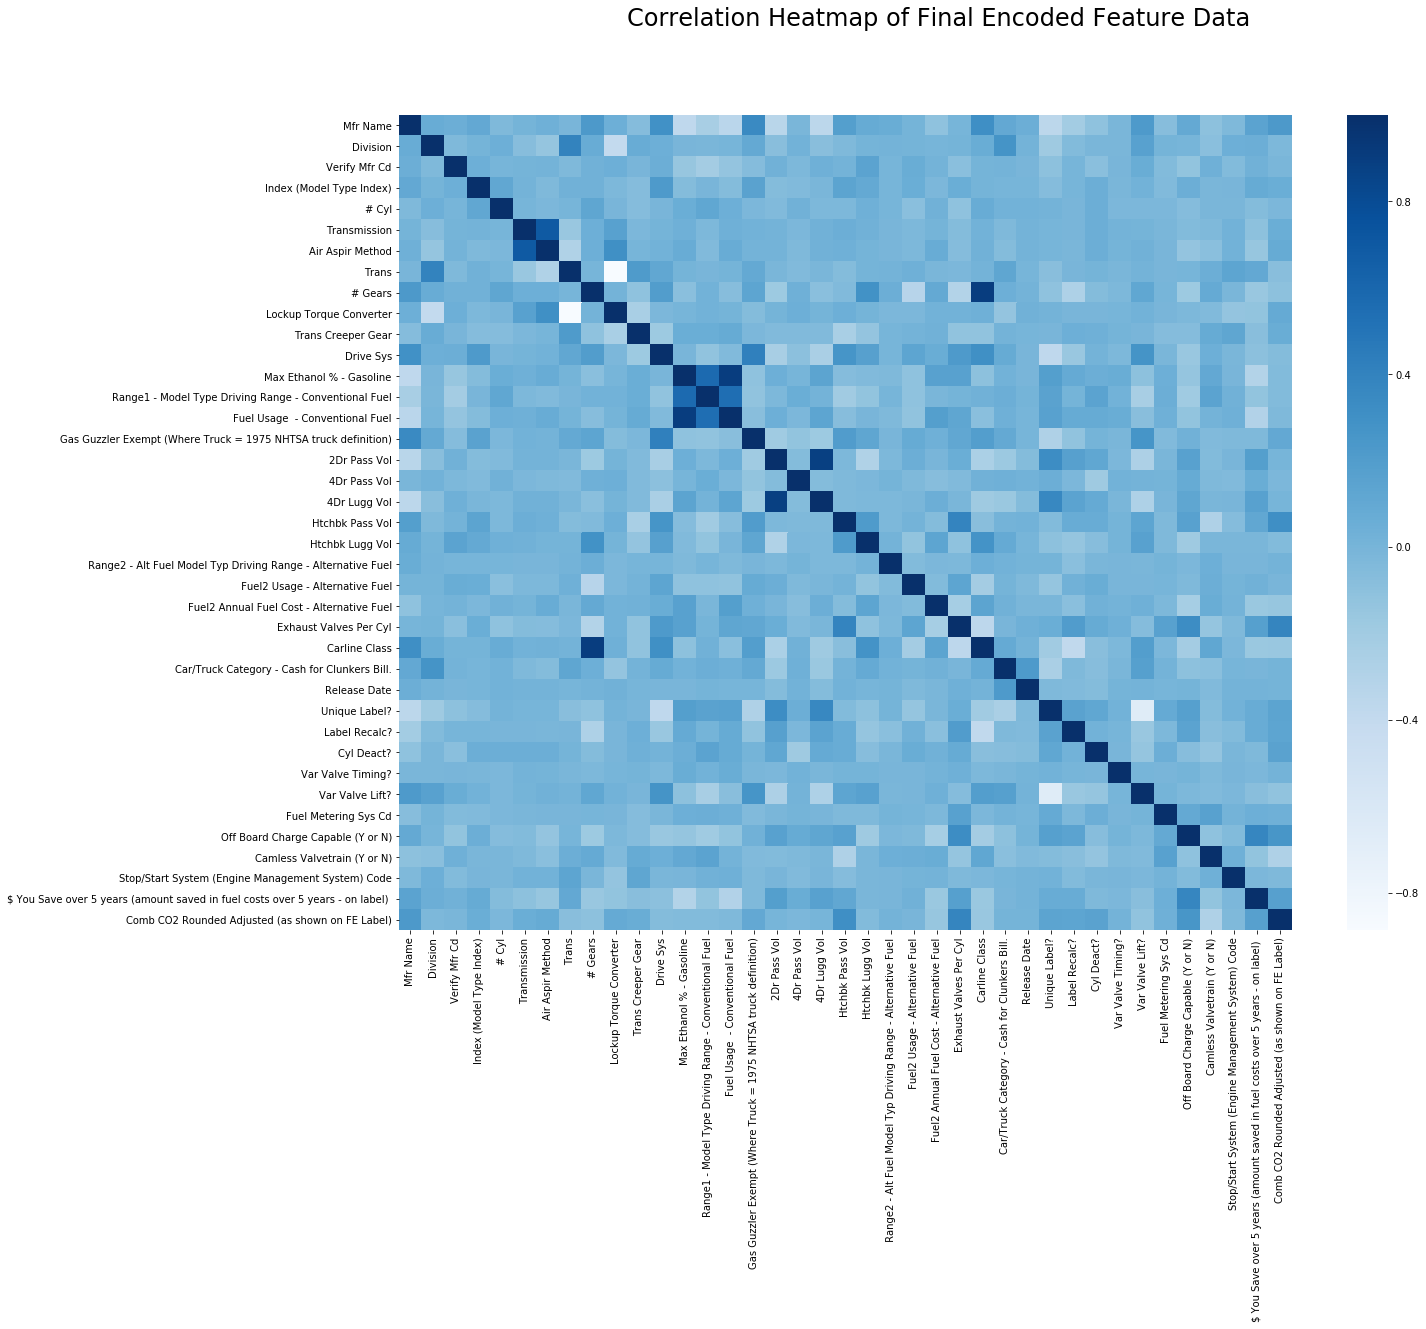

In [85]:
cov = np.corrcoef(encoded_cat_data_imputed, rowvar=False)

plt.figure(figsize=(20,15))
sns.heatmap(cov, cmap = 'Blues',xticklabels=encoded_data.columns,
            yticklabels=encoded_data.columns)
plt.suptitle('Correlation Heatmap of Final Encoded Feature Data', fontsize = 24)
plt.show()

**We observe that the correlation among features is now significantly reduced**

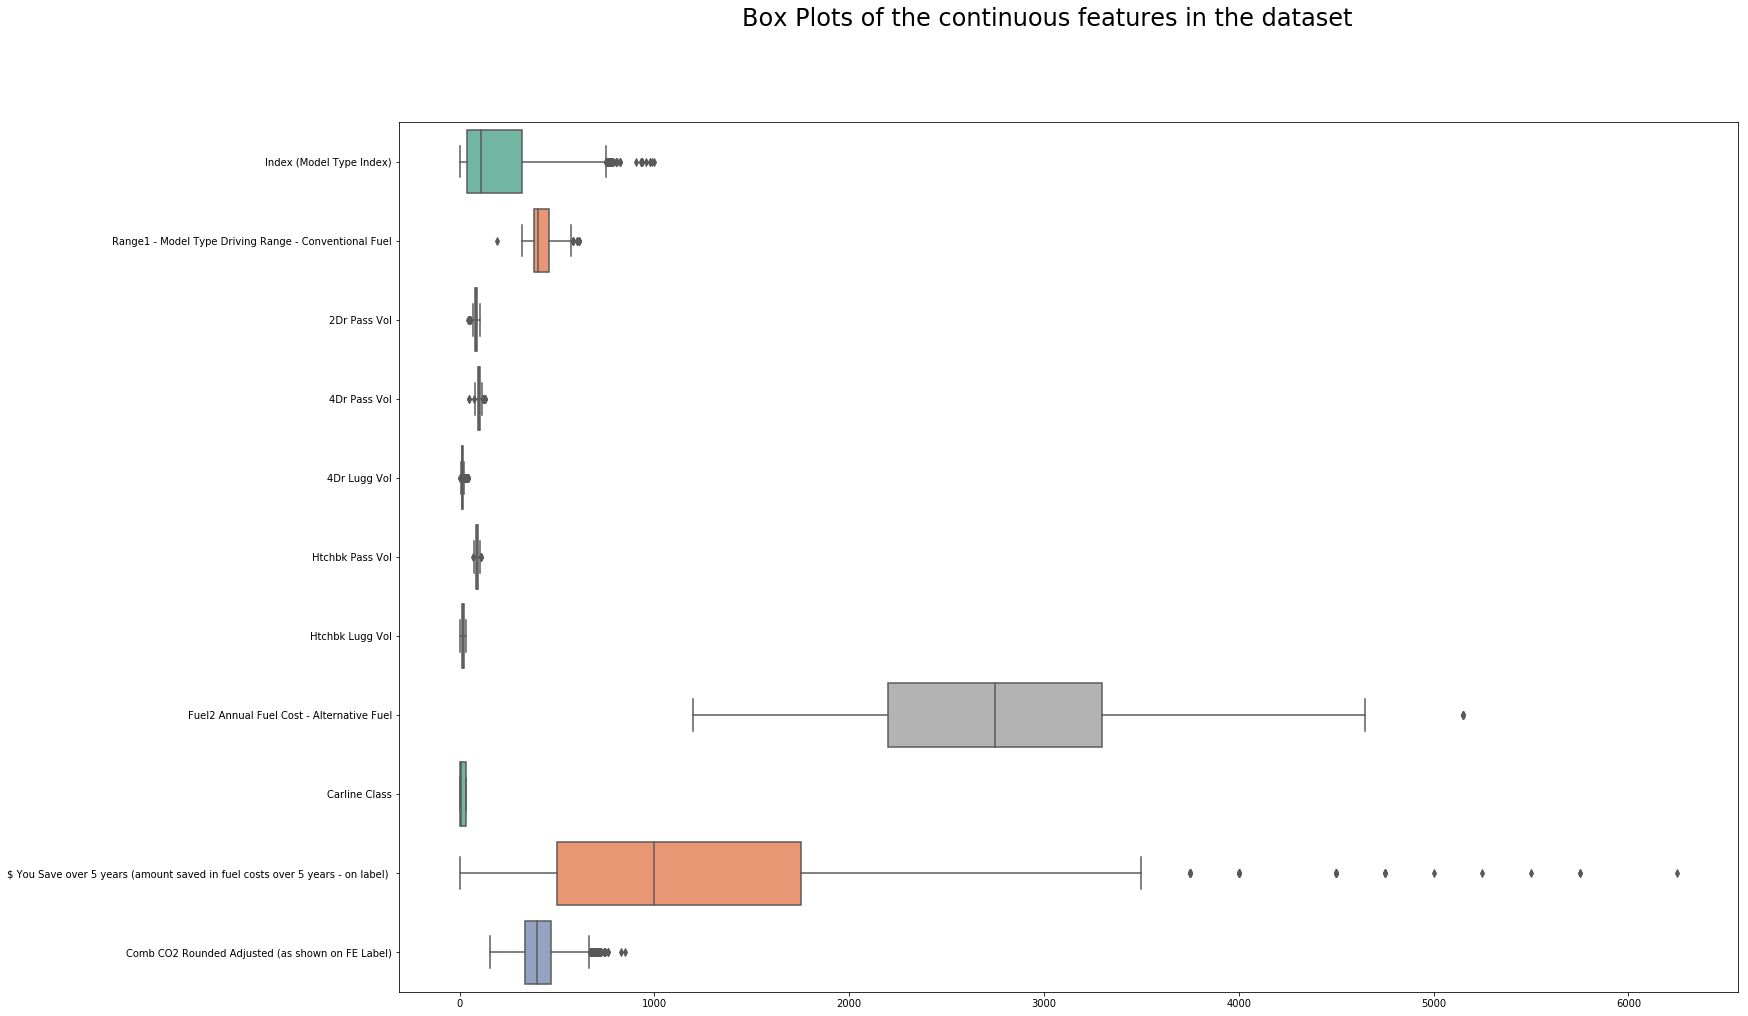

In [86]:
float_check = raw_data.dtypes == float
float_check_list = list(float_check[float_check == True].index)
plt.figure(figsize = (24,16))
plt.suptitle("Box Plots of the continuous features in the dataset",fontsize = 24)
temp = [x for x in float_check_list if x != 'Release Date']
ax = sns.boxplot( data = encoded_data[temp] ,orient="h", palette="Set2") 
plt.show()            

**From the box plots we observe the following:**
1. There are outliers that need to be handled
2. The scales of the features are to be adjusted

In [87]:
final_imputed_df[cat_check_list] = final_imputed_df[cat_check_list].round(0)

In [88]:
impu_enc_df = pd.get_dummies(final_imputed_df, columns=cat_check_list)

In [89]:
new_imputed_categorical_columns = [x for x in list(impu_enc_df.columns)
                                   if x not in list(final_imputed_df.columns) ]

In [90]:
scaler = preprocessing.StandardScaler()
X_train = np.array(impu_enc_df.values, copy=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
scaled_df = pd.DataFrame(X_train_scaled, columns= impu_enc_df.columns)

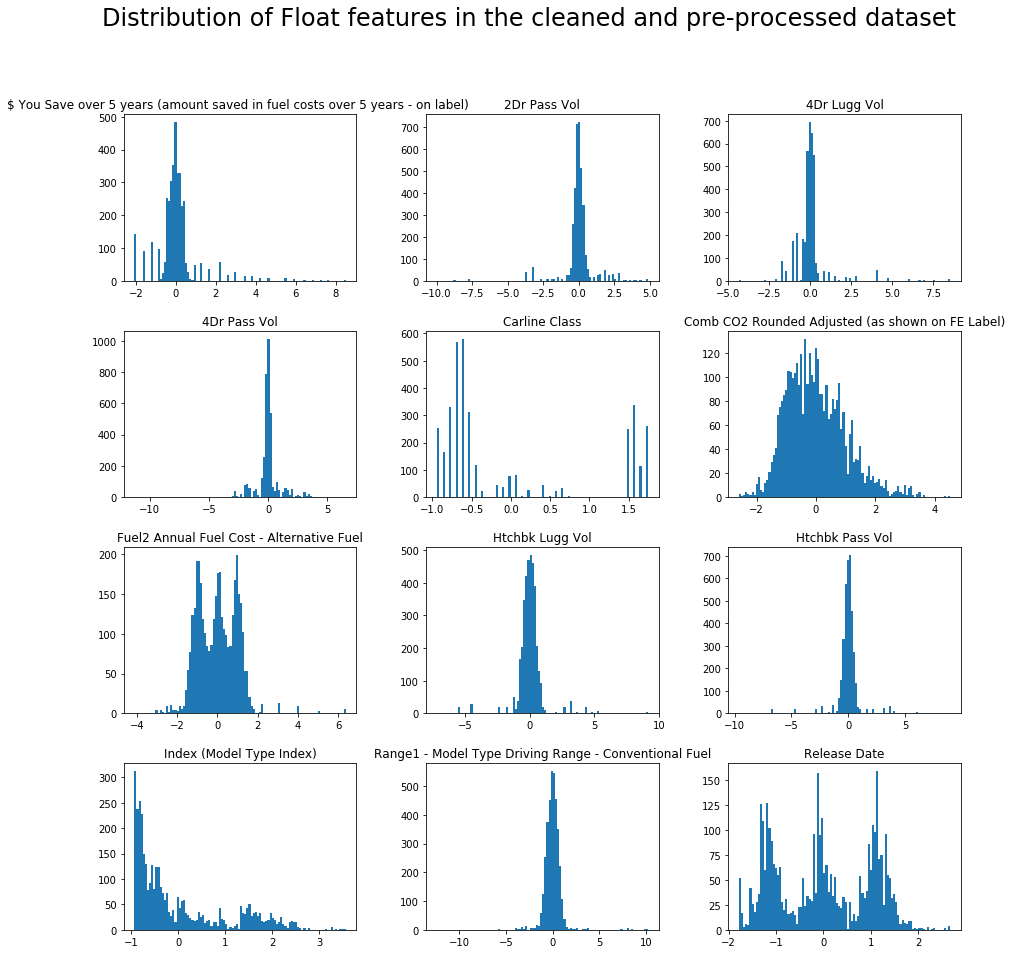

In [91]:
scaled_df[float_check_list].hist(figsize = (15,15), bins = 100, grid = False)
plt.suptitle('Distribution of Float features in the cleaned and pre-processed dataset', 
             fontsize=24)
plt.show()

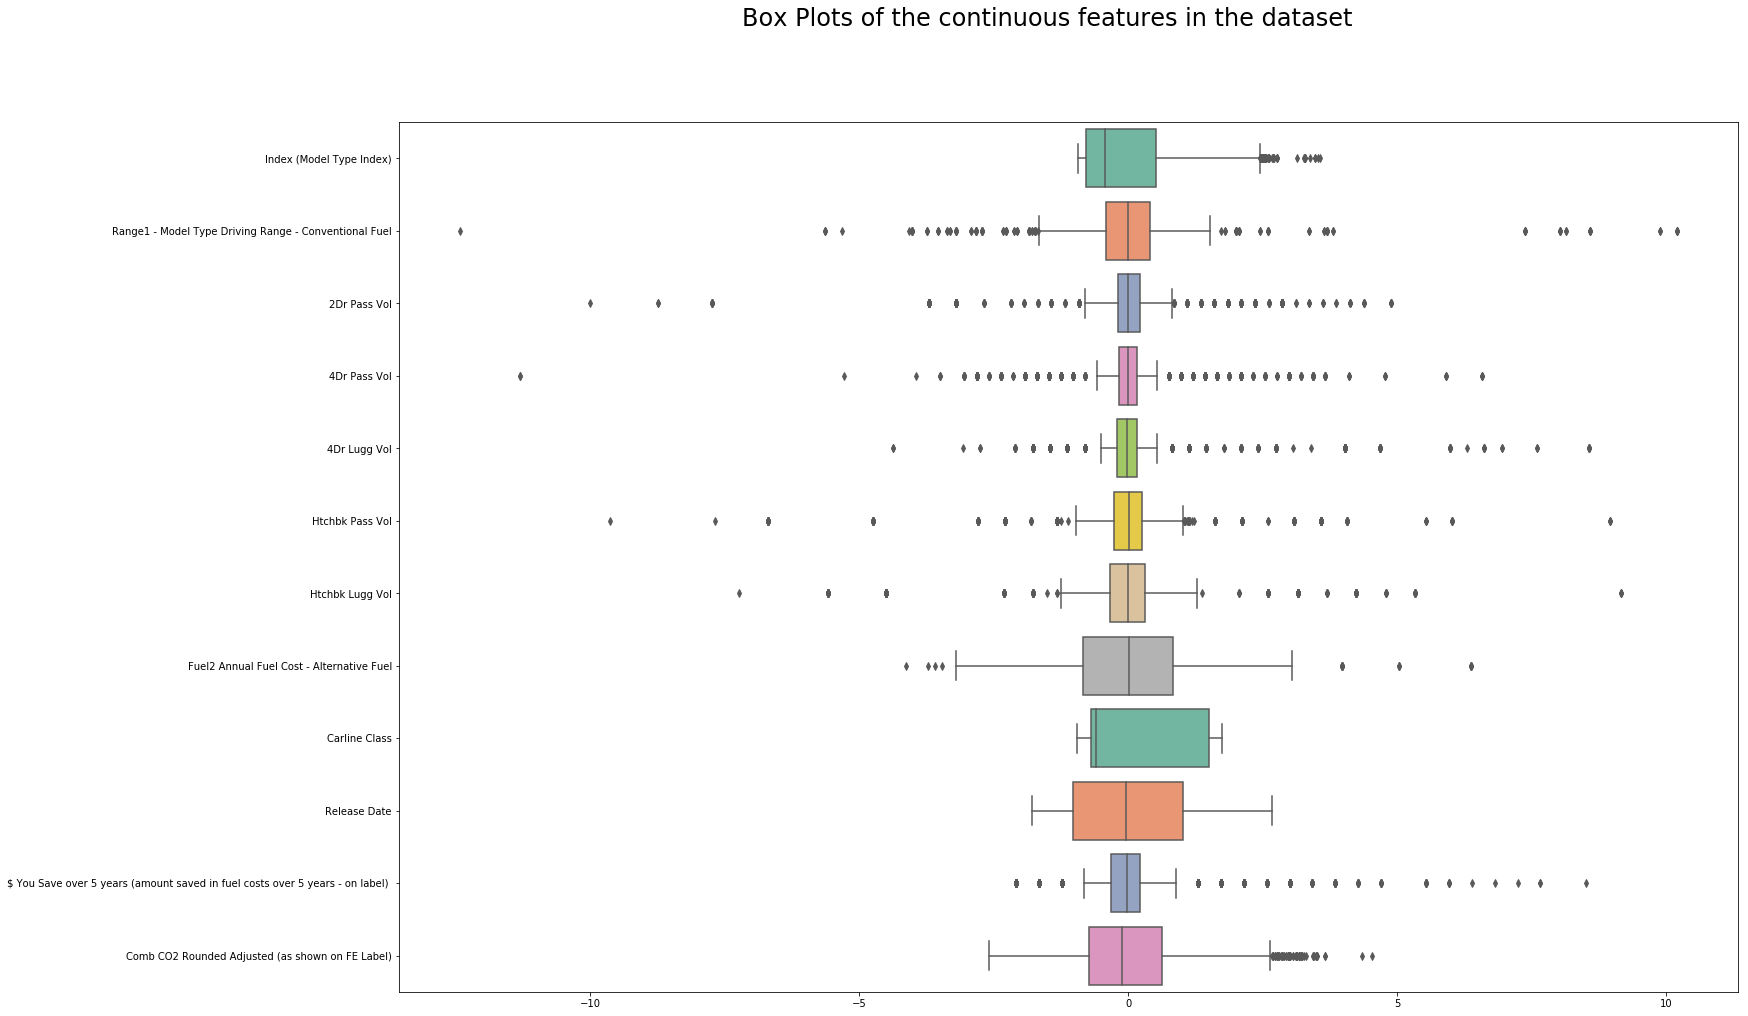

In [92]:
plt.figure(figsize = (24,16))
plt.suptitle("Box Plots of the continuous features in the dataset",fontsize = 24)
ax = sns.boxplot( data = scaled_df[float_check_list] ,orient="h", palette="Set2") 
plt.show()

## **Fitting linear models:**

In [93]:
scaled_df.drop(columns=['Comb CO2 Rounded Adjusted (as shown on FE Label)'],
               inplace= True)

In [94]:
#ridge regression
x_train,x_test,y_train,y_test=sksplit(scaled_df.values,target,random_state=17)

In [95]:
ridge_regression_accuracy = np.mean(cross_val_score(lm.Ridge(),x_train,y_train))
print("Ridge regression accuracy is:", ridge_regression_accuracy)

Ridge regression accuracy is: 0.8681743381862876


**Ridge regression with Gridsearch**

In [96]:
#ridge regression with gridsearch
param_grid = {'alpha': np.logspace(-3, 3, 13)}
grid = GridSearchCV(lm.Ridge(), param_grid, cv=10,return_train_score=True)
grid.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.00000e-03, 3.16228e-03, 1.00000e-02, 3.16228e-02, 1.00000e-01,
       3.16228e-01, 1.00000e+00, 3.16228e+00, 1.00000e+01, 3.16228e+01,
       1.00000e+02, 3.16228e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

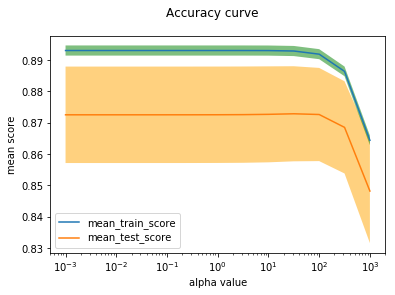

In [97]:
grid_results = pd.DataFrame(grid.cv_results_)
y_train_mean = grid_results['mean_train_score']
y_train_std = grid_results['std_train_score']
y_test_mean = grid_results['mean_test_score']
y_test_std = grid_results['std_test_score']
#gridsearch_cv_model_scores['ridge_regression'] =np.mean(y_test_mean)
x = param_grid['alpha']
line1,=plt.plot(x,y_train_mean)
line2,=plt.plot(x,y_test_mean)
plt.fill_between(x, y_test_mean - y_test_std,y_test_mean + y_test_std,
                 facecolor = 'orange', alpha = 0.5)
plt.fill_between(x, y_train_mean - y_train_std,y_train_mean + y_train_std,
                 facecolor = 'green', alpha = 0.5)
plt.xticks(x)
plt.legend(handles=[line1,line2], loc=3)
plt.xlabel('alpha value')
plt.ylabel('mean score')
plt.suptitle('Accuracy curve')
plt.xscale('log')

In [98]:
best_ridge = grid.best_estimator_
print("Training score with ridge best estimator is {}".format
      (best_ridge.score(x_train, y_train)))
print("Test score with ridge best estimator is {}".format
      (best_ridge.score(x_test, y_test)))

Training score with ridge best estimator is 0.8920455808952504
Test score with ridge best estimator is 0.8783314510288914


# Task 2 Feature Engineering
**Build non-linear features or derived features from the provided column. Try to improve the
performance of a linear model with these.**

## **Building Polynomial features:**

In [100]:
float_features_for_poly = [x for x in list(scaled_df.columns) 
                           if x in float_check_list]
scaled_df_for_poly = scaled_df[float_features_for_poly]
float_poly = PolynomialFeatures(include_bias=False)
scaled_df_float_poly = float_poly.fit_transform(scaled_df_for_poly)
scaled_df_categorical = scaled_df[new_imputed_categorical_columns]
final_poly_data = np.concatenate((scaled_df_float_poly,scaled_df_categorical.values),
                                 axis=1)

## Fitting Linear Models:

In [101]:
x_train_poly,x_test_poly,y_train_poly,y_test_poly=sksplit(final_poly_data,
                                                          target,random_state=17)

### Ridge and lasso regression with polynomial features:

In [102]:
poly_ridge_regression_accuracy = np.mean(cross_val_score(lm.Ridge(),
                                                         x_train_poly,y_train_poly))
poly_lasso_regression_accuracy = np.mean(cross_val_score(lm.Lasso(),
                                                         x_train_poly,y_train_poly))

print("poly ridge regression mean accuracy with default parameters is:", 
      poly_ridge_regression_accuracy)
print("poly lasso regression mean accuracy with default parameters is:", 
      poly_lasso_regression_accuracy)

poly ridge regression mean accuracy with default parameters is: 0.880623660904032
poly lasso regression mean accuracy with default parameters is: 0.637554718225798


### ridge regression with gridsearch and polynomial features

In [103]:
param_grid_poly = {'alpha': np.logspace(-3, 4, 13)}
ridge_poly_grid = GridSearchCV(lm.Ridge(), param_grid_poly, cv=10,
                               return_train_score=True)
ridge_poly_grid.fit(x_train_poly, y_train_poly)

GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.00000e-03, 3.83119e-03, 1.46780e-02, 5.62341e-02, 2.15443e-01,
       8.25404e-01, 3.16228e+00, 1.21153e+01, 4.64159e+01, 1.77828e+02,
       6.81292e+02, 2.61016e+03, 1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

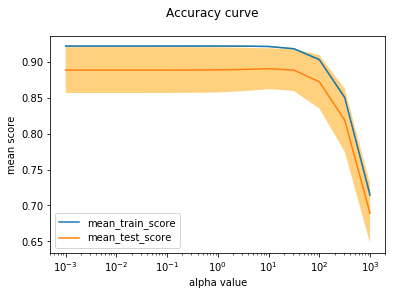

In [104]:
ridge_poly_grid_results = pd.DataFrame(ridge_poly_grid.cv_results_)
y_train_mean = ridge_poly_grid_results['mean_train_score']
y_train_std = ridge_poly_grid_results['std_train_score']
y_test_mean = ridge_poly_grid_results['mean_test_score']
y_test_std = ridge_poly_grid_results['std_test_score']
#gridsearch_cv_model_scores['ridge_regression'] =np.mean(y_test_mean)
x = param_grid['alpha']
line1,=plt.plot(x,y_train_mean)
line2,=plt.plot(x,y_test_mean)
plt.fill_between(x, y_test_mean - y_test_std,y_test_mean + y_test_std,
                 facecolor = 'orange', alpha = 0.5)
plt.fill_between(x, y_train_mean - y_train_std,y_train_mean + y_train_std,
                 facecolor = 'green', alpha = 0.5)
plt.xticks(x)
plt.legend(handles=[line1,line2], loc=3)
plt.xlabel('alpha value')
plt.ylabel('mean score')
plt.suptitle('Accuracy curve')
plt.xscale('log')

#### Best Estimator Performace:

In [105]:
ridge_poly_best_estimator = ridge_poly_grid.best_estimator_
print("ridge regression best nparameter for polynomial features is:",
      ridge_poly_grid.best_params_)
print("Training score with ridge best estimator and polynomial features is {}".format
      (ridge_poly_best_estimator.score(x_train_poly, y_train_poly)))
print("Test score with ridge best estimator and polynomial features is {}".format
      (ridge_poly_best_estimator.score(x_test_poly, y_test_poly)))

ridge regression best nparameter for polynomial features is: {'alpha': 46.41588833612782}
Training score with ridge best estimator and polynomial features is 0.9207365330309913
Test score with ridge best estimator and polynomial features is 0.8997374688505894


#### Plotting coefficient values:

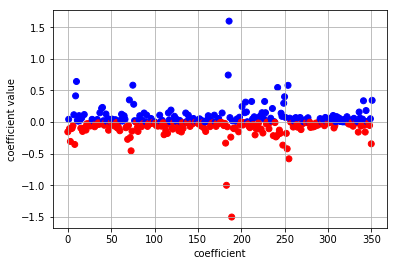

In [106]:
plt.scatter(range(x_train_poly.shape[1]), ridge_poly_best_estimator.coef_,
            c= np.sign(ridge_poly_best_estimator.coef_), cmap="bwr_r")
plt.xlabel("coefficient")
plt.ylabel("coefficient value")
plt.grid()
plt.show()

### Lasso regression with gridsearch and polynomial features

In [107]:

param_grid_poly = {'alpha': np.logspace(-3, 4, 13)}
lasso_poly_grid = GridSearchCV(lm.Lasso(), param_grid_poly, cv=10,
                               return_train_score=True)
lasso_poly_grid.fit(x_train_poly, y_train_poly)

GridSearchCV(cv=10, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.00000e-03, 3.83119e-03, 1.46780e-02, 5.62341e-02, 2.15443e-01,
       8.25404e-01, 3.16228e+00, 1.21153e+01, 4.64159e+01, 1.77828e+02,
       6.81292e+02, 2.61016e+03, 1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

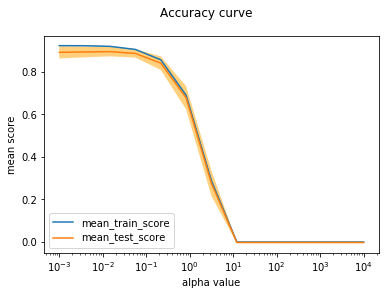

In [108]:
lasso_poly_grid_results = pd.DataFrame(lasso_poly_grid.cv_results_)
y_train_mean = lasso_poly_grid_results['mean_train_score']
y_train_std = lasso_poly_grid_results['std_train_score']
y_test_mean = lasso_poly_grid_results['mean_test_score']
y_test_std = lasso_poly_grid_results['std_test_score']

x = param_grid_poly['alpha']
line1,=plt.plot(x,y_train_mean)
line2,=plt.plot(x,y_test_mean)
plt.fill_between(x, y_test_mean - y_test_std,y_test_mean + y_test_std,
                 facecolor = 'orange', alpha = 0.5)
plt.fill_between(x, y_train_mean - y_train_std,y_train_mean + y_train_std,
                 facecolor = 'green', alpha = 0.5)
plt.xticks(x)
plt.legend(handles=[line1,line2], loc=3)
plt.xlabel('alpha value')
plt.ylabel('mean score')
plt.suptitle('Accuracy curve')
plt.xscale('log')

#### Best estimator performance:

In [109]:
lasso_poly_best_estimator = lasso_poly_grid.best_estimator_
print("lasso regression best nparameter for polynomial features is:",
      lasso_poly_grid.best_params_)
print("Training score with lasso best estimator and polynomial features is {}".
      format(lasso_poly_best_estimator.score(x_train_poly, y_train_poly)))
print("Test score with lasso best estimator and polynomial features is {}".
      format(lasso_poly_best_estimator.score(x_test_poly, y_test_poly)))

lasso regression best nparameter for polynomial features is: {'alpha': 0.014677992676220698}
Training score with lasso best estimator and polynomial features is 0.9178559779155824
Test score with lasso best estimator and polynomial features is 0.8993865689890023


#### Plotting the coefficients:

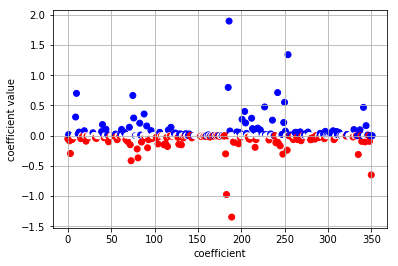

In [110]:
plt.scatter(range(x_train_poly.shape[1]), lasso_poly_best_estimator.coef_,
            c= np.sign(lasso_poly_best_estimator.coef_), cmap="bwr_r")
plt.xlabel("coefficient")
plt.ylabel("coefficient value")
plt.grid()
plt.show()

# Task 3 Any models
**Use any regression model we discussed (trees, forests, gradient boosting, SVM) to improve
your result. You can (and probably should) change your preprocessing and feature engineering
to be suitable for the model. You are not required to try all of these models.**

### Analyzing performance with different models:

#### Random Forests:

In [111]:
rand_for_regr = ensemble.RandomForestRegressor(n_estimators=20,
                                               max_depth= 150, random_state = 17)
rand_for_regr.fit(x_train, y_train)
rand_for_train_score = rand_for_regr.score(x_train, y_train)
rand_for_test_score = rand_for_regr.score(x_test, y_test)
print("Random forest regressor training score:", rand_for_train_score)
print("Random forest regressor test score:", rand_for_test_score)

Random forest regressor training score: 0.9927226445862023
Random forest regressor test score: 0.9549116774760488


#### Gradient Boosting Methods:

In [112]:
grad_bos_regr = ensemble.GradientBoostingRegressor()
grad_bos_regr.fit(x_train, y_train)
print("Gradient Boosting Regressor training score:",
      grad_bos_regr.score(x_train, y_train))
print("Gradient Boosting Regressor test score:",
      grad_bos_regr.score(x_test, y_test))

Gradient Boosting Regressor training score: 0.9386372661650193
Gradient Boosting Regressor test score: 0.9229733383444809


#### Extra Tree Regressor:

In [113]:
from sklearn.tree import ExtraTreeRegressor

extra_tree_regr = ExtraTreeRegressor( max_depth= 150)
extra_tree_regr.fit(x_train, y_train)
print("Extra Tree Regressor training score:",extra_tree_regr.score(x_train, y_train))
print("Extra Tree Regressor test score:",extra_tree_regr.score(x_test, y_test))

Extra Tree Regressor training score: 0.9999999999947115
Extra Tree Regressor test score: 0.9333272525333853


### Observations:


* We got the best accuracy for Random Forests so we proceed with feature selection for this model
* **Our best model is Random Forests**

# Task 4 Feature Selections
**Identify features that are important for your best model. Which features are most influential,
and which features could be removed without decrease in performance? Does removing
irrelevant features make your model better?**

## Analysis:

In [114]:
rand_feat_w = rand_for_regr.feature_importances_

#### Picking features with top 108 feature importances:

In [115]:
imp_feat = np.abs(rand_feat_w).argsort()[rand_feat_w.shape[0]-108:]
x_train_imp_feat = x_train.T[imp_feat].T
x_test_imp_feat = x_test.T[imp_feat].T

#### Random Forests Model Performance top 108 feature :

In [116]:
rand_for_regr_imp = ensemble.RandomForestRegressor(n_estimators=20,
                                                   max_depth= 150, random_state=17)
rand_for_regr_imp.fit(x_train_imp_feat, y_train)
rand_for_train_score_imp = rand_for_regr_imp.score(x_train_imp_feat, y_train)
rand_for_test_score_imp = rand_for_regr_imp.score(x_test_imp_feat, y_test)
print("Random forest regressor training score:", rand_for_train_score_imp)
print("Random forest regressor test score:", rand_for_test_score_imp)

Random forest regressor training score: 0.992320098720153
Random forest regressor test score: 0.9528460192608018


#### Picking features with bottom 168 feature importances:

In [117]:
unimp_feat = np.abs(rand_feat_w).argsort()[:168]
x_train_unimp_feat = x_train.T[unimp_feat].T
x_test_unimp_feat = x_test.T[unimp_feat].T

#### Random Forests Model Performance with bottom 168 features :

In [118]:
rand_for_regr_unimp = ensemble.RandomForestRegressor(n_estimators=20,
                                                     max_depth= 150,random_state=17)
rand_for_regr_unimp.fit(x_train_unimp_feat, y_train)
rand_for_train_score = rand_for_regr_unimp.score(x_train_unimp_feat, y_train)
rand_for_test_score = rand_for_regr_unimp.score(x_test_unimp_feat, y_test)
print("Random forest regressor training score :", rand_for_train_score)
print("Random forest regressor test score:", rand_for_test_score)

Random forest regressor training score : 0.6994716625419477
Random forest regressor test score: 0.4508139706886186


## Observations:

**As per the performance results above, we can conclude that:**
    * The test performance of the model remains nearly the same when we run the model with only top 108 features
        * Full Model - 0.9530
        * Model with top features - 0.9522
    * The bottom 168 features capture only about 50% of the original model accuracy
        * Full Model - 0.9530
        * Model with top features - 0.4691

## Results:

#### The following features of the dataset are important and relevant to the model:

In [119]:
imp_feat_df = pd.DataFrame(scaled_df.columns[imp_feat],columns = ['Features'])

In [120]:
print(imp_feat_df)

                                              Features
0     Range2 - Alt Fuel Model Typ Driving Range - A...
1                                        Division_46.0
2     Car/Truck Category - Cash for Clunkers Bill._1.0
3                             Fuel Metering Sys Cd_3.0
4                                        Division_30.0
5                                         Mfr Name_8.0
6     Range2 - Alt Fuel Model Typ Driving Range - A...
7                                   Verify Mfr Cd_17.0
8     Range2 - Alt Fuel Model Typ Driving Range - A...
9                                         Mfr Name_2.0
10                                       Drive Sys_3.0
11                                       Drive Sys_0.0
12                                Air Aspir Method_0.0
13                                  Verify Mfr Cd_24.0
14                                           Trans_4.0
15                                       Mfr Name_24.0
16                               Var Valve Timing?_1.0
17        

#### Does removing irrelevant features make your model better?

* The test performance of the model remains **nearly the same** and **does not improve** when we run the model with only top 108 features and ignore the irrelevant bottom 168 features:
    * **Full Model** - 0.9530
    * **Model with top features** - 0.9522